In [1]:
import os
# set the appropriate path to whichever R installation we'd like to use
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from fnc_analysis import *
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg
from pathlib import Path
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [3]:
# figure settings
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['svg.fonttype']='none'
fig_save_loc = Path('figures')
stat_save_loc = Path('stats/raw')
os.makedirs(fig_save_loc/'pdfs', exist_ok=True) 
os.makedirs(fig_save_loc/'svgs', exist_ok=True) 
os.makedirs(stat_save_loc, exist_ok=True) 
ctl_col = '#D4D4D4'
stim_col = '#06e1e9'

In [4]:
# load tidy data and subset dataframes for later use
data_dir = "../../data/behavior"

#load unlimited intake
df = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/total_licks_normal_intake.csv'))
dft = load_data(os.path.join(data_dir,'pre_processed/unlimited_intake/lick_times_normal_intake.csv'))

#load limited intake
df_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/total_licks_limited_intake.csv'))
dft_ltd = load_data(os.path.join(data_dir,'pre_processed/limited_intake/lick_times_limited_intake.csv'))

#load extinction
df_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/total_licks_extinction3.csv'))
dft_ex = load_data(os.path.join(data_dir,'pre_processed/extinction3/lick_times_extinction3.csv'))

#load extinction pt2
df_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/total_licks_extinction4.csv'))
dft_ex2 = load_data(os.path.join(data_dir,'pre_processed/extinction4/lick_times_extinction4.csv'))


#select glucose data
#unlimited intake
df_test_g = subset_df(df, 'glucose', 'test')
dft_test_g = subset_df(dft, 'glucose', 'test')

df_train_g = subset_df(df, 'glucose', 'training')
dft_train_g = subset_df(dft, 'glucose', 'training')


#limited intake
df_test_g_ltd = subset_df(df_ltd, 'glucose', 'test')
dft_test_g_ltd = subset_df(dft_ltd, 'glucose', 'test')

df_train_g_ltd = subset_df(df_ltd, 'glucose', 'training')
dft_train_g_ltd = subset_df(dft_ltd, 'glucose', 'training')


#extinction
df_test_g_ex = subset_df(df_ex, 'glucose', 'test') 
dft_test_g_ex = subset_df(dft_ex, 'glucose', 'test') 

df_train_g_ex = subset_df(df_ex, 'glucose', 'training') 
dft_train_g_ex = subset_df(dft_ex, 'glucose', 'training') 

#extinction 2
df_test_g_ex2 = subset_df(df_ex2, 'glucose', 'test')
dft_test_g_ex2 = subset_df(dft_ex2, 'glucose', 'test')

df_train_g_ex2 = subset_df(df_ex2, 'glucose', 'training')
dft_train_g_ex2 = subset_df(dft_ex2, 'glucose', 'training')

#combine
df_test_g_ltd_cohort = pd.concat({0: df_test_g_ltd, 
                                  1: df_test_g_ex.loc[:,:,:1], 
                                  2: df_test_g_ex2.loc[:,:,:1]}, 
                                 names=['cohort'])
df_test_g_ltd = df_test_g_ltd_cohort.droplevel('cohort')

dft_test_g_ltd_cohort = pd.concat({0: dft_test_g_ltd, 
                                   1: dft_test_g_ex.loc[:,:,:1], 
                                   2: dft_test_g_ex2.loc[:,:,:1]}, 
                                  names=['cohort'])
dft_test_g_ltd = dft_test_g_ltd_cohort.droplevel('cohort')


df_train_g_ltd_cohort = pd.concat({0: df_train_g_ltd, 
                                   1: df_train_g_ex.loc[:,:,:1], 
                                   2: df_train_g_ex2.loc[:,:,:1]}, 
                                  names=['cohort'])
df_train_g_ltd = df_train_g_ltd_cohort.droplevel('cohort')


dft_train_g_ltd_cohort = pd.concat({0: dft_train_g_ltd, 
                                    1: dft_train_g_ex.loc[:,:,:1], 
                                    2: dft_train_g_ex2.loc[:,:,:1]}, 
                                   names=['cohort'])
dft_train_g_ltd = dft_train_g_ltd_cohort.droplevel('cohort')

#select fat data
#unlimited intake
df_test_f = subset_df(df, 'fat', 'test') 
dft_test_f = subset_df(dft, 'fat', 'test') 

df_train_f = subset_df(df, 'fat', 'training') 
dft_train_f = subset_df(dft, 'fat', 'training') 

#limited intake
df_test_f_ltd = subset_df(df_ltd, 'fat', 'test') 
dft_test_f_ltd = subset_df(dft_ltd, 'fat', 'test') 

df_train_f_ltd = subset_df(df_ltd, 'fat', 'training')
dft_train_f_ltd = subset_df(dft_ltd, 'fat', 'training')

## Figure 1 - unlimited intake, food deprived
In these experiments, mice were maintained at ~90% of their body weight throughout training and testing. During the training sessions they were allowed unrestricted access to the flavored solutions. 

In [5]:
#@title general stats
print("Glucose:")
print("Controls: n = ",df_test_g.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ", df_test_g.loc[True,].index.get_level_values('mouse').unique().size)
print("\nFat:")
print("Controls: n = ",df_test_f.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ", df_test_f.loc[True,].index.get_level_values('mouse').unique().size)

Glucose:
Controls: n =  15
Stim: n =  14

Fat:
Controls: n =  15
Stim: n =  14


### schematic

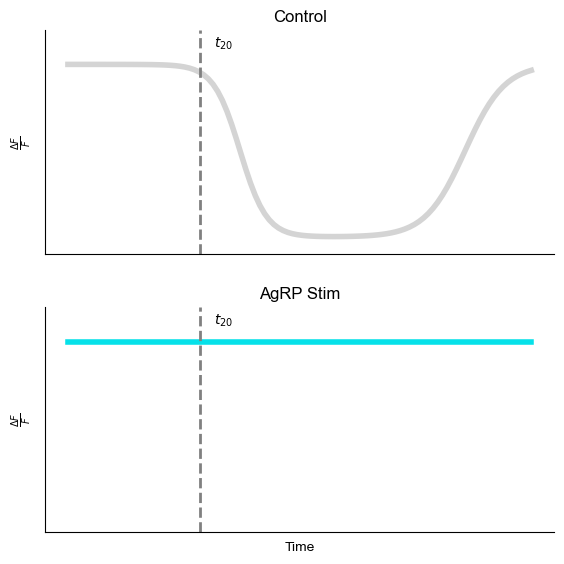

In [6]:
from scipy.special import expit
x = np.linspace(-10,25,100)
fig, ax = plt.subplots(2,1, figsize = (6,6))
ax[0].plot(x, -expit(x-3) + expit((x-20)/1.5), c = ctl_col, lw = 4)
ax[0].axvline(0, ls = '--', c = 'gray', lw = 2)
ax[0].text(1,0.1,r'$t_{20}$')

ax[0].set(ylim = (-1.1,.2),
          xticks = [], yticks = [],
          ylabel = r'$\frac{\Delta F}{F}$',
          title = "Control")
ax[1].plot(x, [0]*x.size,  c= stim_col, lw = 4)
ax[1].axvline(0, ls = '--', c = 'gray', lw = 2)
ax[1].text(1,0.1,r'$t_{20}$')

ax[1].set(ylim = ax[0].get_ylim(),
          xticks = [], yticks = [],
          xlabel = 'Time', 
          ylabel = r'$\frac{\Delta F}{F}$',
          title = "AgRP Stim")

sns.despine()
fig.tight_layout(pad = 2.)
fig.savefig(fig_save_loc/'pdfs'/'fig1_schematic.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig1_schematic.svg', transparent=True, bbox_inches='tight')

### validating feeding for normal intake cohort

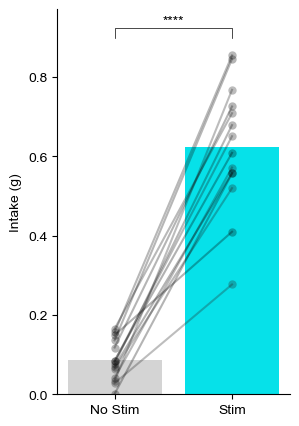

In [7]:
normal_intake = (pd.read_csv(os.path.join(data_dir,"raw_data/normal_intake/opto_validation.csv"), index_col = 0)
                   .stack()
                   .reset_index()
                   .rename(columns = {'Mouse ': 'mouse', 
                                      "level_1": 'stim', 
                                      0:'intake'})
                   .set_index('mouse')
                   .loc[df_test_g.loc[True,].index.get_level_values('mouse').unique()]
                   .reset_index()
                )

_,ax = plt.subplots(1,1, figsize = (3,5))
sns.barplot(data=normal_intake, x = 'stim', y = 'intake', saturation = 1,
            errorbar = None, palette = [ctl_col, stim_col], ax = ax)
sns.lineplot(normal_intake, x='stim', y='intake', hue='mouse', palette='dark:k', 
             alpha=0.3, marker = 'o', markeredgewidth=0, legend=False)

normal_intake = normal_intake.set_index(['mouse','stim']).intake.unstack('stim')
fint_stat = st.ttest_rel(normal_intake['no_stim '], normal_intake['stim'])

plot_significance(fint_stat[1], ax=ax,x1=0,x2=1,yy=0.9, h=.025)

sns.despine()
plt.ylabel("Intake (g)")
plt.xticks([0,1], ['No Stim', 'Stim'])
plt.xlabel("")
plt.savefig("figures/svgs/fig1_opto_feeding_val.svg")
plt.savefig("figures/pdfs/fig1_opto_feeding_val.pdf")

#### stats

In [8]:
fig1_stats = {}

In [9]:
fint_stat = pd.Series(list(fint_stat) + [fint_stat.df], index = ('t', 'p-value', 'df')).rename('t-test').to_frame().T
fint_stat['Significance'] = fint_stat['p-value'].apply(check_significance)
display(fint_stat)

fig1_stats.update({"c_stim_food_intake_stats": fint_stat})

,t,p-value,df,Significance
t-test,-13.856584,3.656564e-09,13.0,****


### main plots

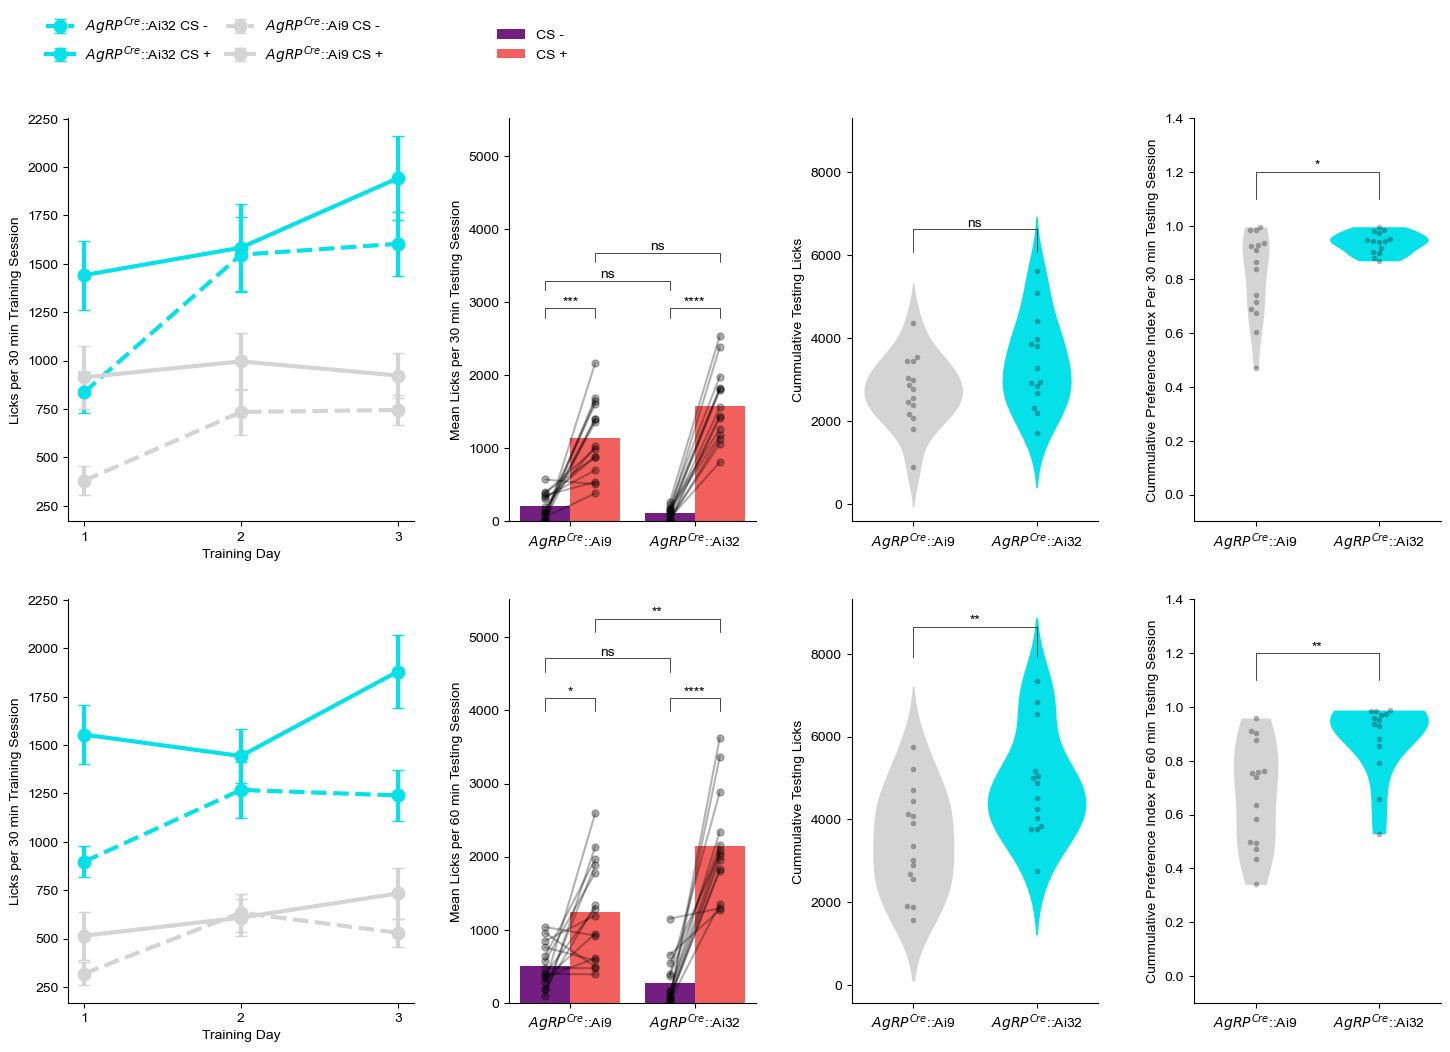

In [10]:
# create the subplot
fig, ax = plt.subplots(2,4, figsize=(15,11), gridspec_kw = {'width_ratios': [1.4, 1, 1, 1]})

# create training plots
training_plot(df_train_g.loc[True,], df_train_g.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0,0]);
training_plot(df_train_f.loc[True,], df_train_f.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[1,0]);


# get the average stim and control testing licks for CS+ vs CS- flavors
# glusose
normal_stim = average_test_data(df_test_g, Chr2=True)
normal_ctl = average_test_data(df_test_g, Chr2=False)
# fat
normal_stim_f = average_test_data(df_test_f, Chr2=True)
normal_ctl_f = average_test_data(df_test_f, Chr2=False)

# plot average cs+ and cs- licks during testing
_, stats_g = two_bottle_plot(normal_stim, normal_ctl, ax=ax[0,1])
_, stats_f = two_bottle_plot(normal_stim_f, normal_ctl_f, ax=ax[1,1], t=60) 


# plot total testing licks
_, stats_g_tot = cumm_test_licks_plot(df_test_g.loc[True,],df_test_g.loc[False,],
                                      palette = [stim_col, ctl_col], ax = ax[0,2])
_, stats_f_tot = cumm_test_licks_plot(df_test_f.loc[True,],df_test_f.loc[False,],
                                      palette = [stim_col, ctl_col], ax = ax[1,2])

# plot the preference indices
_, pref_g, p_pref = two_bottle_pref_plot_vl(df_test_g.loc[True,], df_test_g.loc[False,] , 
                                            ax=ax[0,3], palette = [stim_col, ctl_col]);
_, pref_f, p_pref_f = two_bottle_pref_plot_vl(df_test_f.loc[True,], df_test_f.loc[False,] , 
                                              ax=ax[1,3], t=60, palette = [stim_col, ctl_col]);


# ensure the limits on the y-axes are all the same
for i in range(3):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)



# format legend text
ax[0,0].legend(*ax[0,0].get_legend_handles_labels(), ncol = 2,  columnspacing = 1,
               loc = 'lower left', bbox_to_anchor= (-.1,1.1), frameon = False)
ax[0,1].legend(ax[0,1].get_legend().legendHandles,['CS -', 'CS +'],
               loc = 'lower left', bbox_to_anchor= (-.1,1.11), frameon = False)

#remove legend from bottom row plots
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
fig.tight_layout(pad=2.5)

#save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig1_plots.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig1_plots.svg', transparent=True, bbox_inches='tight')

#### stats

In [11]:
fig1_stats = {}

##### stats - glucose unlimited intake training

In [12]:
df = df_train_g.reset_index()

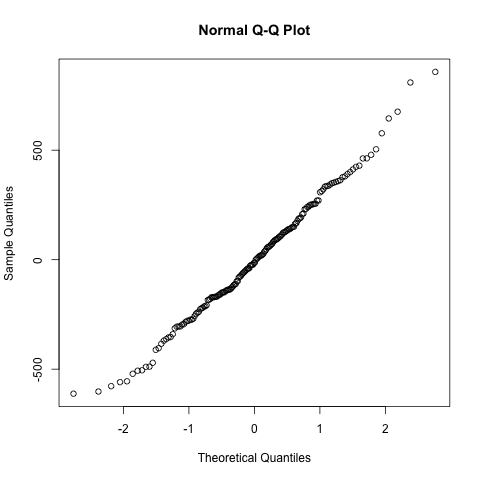

In [13]:
%%R -i df -o train_model_g -o train_anova_g
m <- lmer("total_licks ~ factor(day)*factor(CS)*factor(Chr2) + (1|mouse)", df)
train_model_g <-as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
train_anova_g <- anova(m)

In [14]:
train_model_g['Significance'] = train_model_g['Pr(>|t|)'].apply(check_significance)
train_anova_g['Significance'] = train_anova_g['Pr(>F)'].apply(check_significance)

fig1_stats.update({'e_train_model_g': train_model_g,
                   'e_train_anova_g': train_anova_g})
display(train_model_g, train_anova_g)

,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),378.400000,151.522922,46.390033,2.497312,0.016123,*
factor(day)1,355.666667,116.190958,135.000001,3.061053,0.002662,**
factor(day)2,366.000000,116.190958,135.000001,3.149987,0.002011,**
factor(CS)+,534.400000,116.190958,135.000001,4.599325,0.000010,****
factor(Chr2)TRUE,456.385714,218.078734,46.390033,2.092757,0.041868,*
factor(day)1:factor(CS)+,-272.933333,164.318828,135.000001,-1.660999,0.099034,ns
factor(day)2:factor(CS)+,-356.400000,164.318828,135.000001,-2.168954,0.031838,*
factor(day)1:factor(Chr2)TRUE,356.119048,167.227352,135.000001,2.129550,0.035023,*
factor(day)2:factor(Chr2)TRUE,402.285714,167.227352,135.000001,2.405622,0.017500,*
factor(CS)+:factor(Chr2)TRUE,71.671429,167.227352,135.000001,0.428587,0.668907,ns


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),5.432280e+06,2.716140e+06,2,135.000001,26.825402,1.550850e-10,****
factor(CS),4.615194e+06,4.615194e+06,1,135.000001,45.581019,3.964062e-10,****
factor(Chr2),1.423454e+06,1.423454e+06,1,26.999997,14.058456,8.553946e-04,***
factor(day):factor(CS),1.383419e+06,6.917093e+05,2,135.000001,6.831525,1.492191e-03,**
factor(day):factor(Chr2),1.448683e+06,7.243416e+05,2,135.000001,7.153812,1.114283e-03,**
factor(CS):factor(Chr2),7.298038e+01,7.298038e+01,1,135.000001,0.000721,9.786212e-01,ns
factor(day):factor(CS):factor(Chr2),2.953049e+05,1.476524e+05,2,135.000001,1.458259,2.362818e-01,ns


##### stats - fat unlimited intake training


In [15]:
df = df_train_f.reset_index()

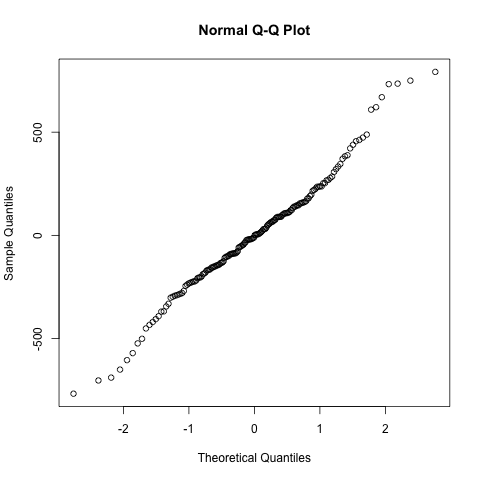

In [16]:
%%R -i df -o train_model_f -o train_anova_f
m <- lmer("total_licks ~ factor(day)*factor(CS)*factor(Chr2) + (1|mouse)", df)
train_model_f <-as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
train_anova_f <- anova(m)

In [17]:
train_model_f['Significance'] = train_model_f['Pr(>|t|)'].apply(check_significance)
train_anova_f['Significance'] = train_anova_f['Pr(>F)'].apply(check_significance)
fig1_stats.update({'i_train_model_f': train_model_f,
                   'i_train_anova_f': train_anova_f})
display(train_model_f, train_anova_f)

,Estimate,Std. Error,df,t value,Pr(>|t|),Significance
(Intercept),318.800000,120.410164,64.121437,2.647617,0.010190,*
factor(day)1,314.933333,113.909333,135.000000,2.764772,0.006493,**
factor(day)2,211.266667,113.909333,135.000000,1.854691,0.065822,ns
factor(CS)+,195.800000,113.909333,135.000000,1.718911,0.087923,ns
factor(Chr2)TRUE,577.914286,173.299828,64.121437,3.334765,0.001422,**
factor(day)1:factor(CS)+,-221.333333,161.092123,135.000000,-1.373955,0.171733,ns
factor(day)2:factor(CS)+,7.200000,161.092123,135.000000,0.044695,0.964417,ns
factor(day)1:factor(Chr2)TRUE,56.423810,163.943532,135.000000,0.344166,0.731257,ns
factor(day)2:factor(Chr2)TRUE,131.733333,163.943532,135.000000,0.803529,0.423082,ns
factor(CS)+:factor(Chr2)TRUE,461.557143,163.943532,135.000000,2.815342,0.005603,**


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Significance
factor(day),2.220082e+06,1.110041e+06,2,135.0,11.406679,2.647436e-05,****
factor(CS),4.113631e+06,4.113631e+06,1,135.0,42.271282,1.419396e-09,****
factor(Chr2),3.507518e+06,3.507518e+06,1,27.0,36.042929,2.095807e-06,****
factor(day):factor(CS),1.178126e+06,5.890629e+05,2,135.0,6.053155,3.036801e-03,**
factor(day):factor(Chr2),2.764846e+05,1.382423e+05,2,135.0,1.420565,2.451652e-01,ns
factor(CS):factor(Chr2),1.459447e+06,1.459447e+06,1,135.0,14.997144,1.671021e-04,***
factor(day):factor(CS):factor(Chr2),1.503688e+05,7.518441e+04,2,135.0,0.772588,4.638472e-01,ns


##### stats - glucose unlimited intake mean total licks during testing stats
We will use a Mixed ANOVA to characterize the lick data followed by pairwise t-tests.

In [18]:
df = df_test_g.groupby(['Chr2','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
test_anova_g = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                              dv = 'total_licks', subject = 'mouse')
test_anova_g = test_anova_g.rename(columns = {'p-unc': 'p-value'})
test_anova_g['Significance'] = test_anova_g['p-value'].apply(check_significance)
stats_g = stats_g.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_g['Significance'] = stats_g['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_g , stats_g)
fig1_stats.update({'f_test_anova_g'   : test_anova_g ,
                   'f_test_posthoc_g' : stats_g})

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1243363880.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_test_g.groupby(['Chr2','mouse','CS']).mean().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.960600  0.702824
      -    0.911952  0.145072
True  +    0.962844  0.769512
      -    0.941924  0.443534

,statistic,p-value
CS,,
+,0.059609,0.808960
-,4.216178,0.049844


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,4.224532e+05,1,27,4.224532e+05,3.505980,7.201558e-02,0.114928,NaN,ns
1,CS,2.068247e+07,1,27,2.068247e+07,132.517874,6.382438e-12,0.830740,1.0,****
2,Interaction,1.041430e+06,1,27,1.041430e+06,6.672708,1.552742e-02,0.198164,NaN,*


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,12.274082,1.593141e-08,6.372564e-08,13,True,****
CS+ vs. CS- $AgRP^{Cre}$::Ai9,5.623017,6.284688e-05,1.885288e-04,14,True,***
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,2.327569,2.769079e-02,5.461479e-02,27,False,ns
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,-1.969110,6.255176e-02,6.255176e-02,27,False,ns


##### stats - fat unlimited intake mean total licks during testing stats

In [19]:
df = df_test_f.groupby(['Chr2','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
test_anova_f = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                              dv = 'total_licks', subject = 'mouse')

test_anova_f = test_anova_f.rename(columns = {'p-unc': 'p-value'})
test_anova_f['Significance'] = test_anova_f['p-value'].apply(check_significance)
stats_f = stats_f.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_f['Significance'] = stats_f['Corrected p-value'].apply(check_significance)


display(shapiro, levene, test_anova_f, stats_f)
fig1_stats.update({'j_test_anova_f'   : test_anova_f,
                   'j_test_posthoc_f' : stats_f})


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/3165632027.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_test_f.groupby(['Chr2','mouse','CS']).mean().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.927676  0.251834
      -    0.943376  0.426726
True  +    0.900371  0.114190
      -    0.768113  0.002067

,statistic,p-value
CS,,
+,0.189864,0.666494
-,0.031974,0.859419


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,1.677503e+06,1,27,1.677503e+06,8.169273,8.109854e-03,0.232284,NaN,**
1,CS,2.396011e+07,1,27,2.396011e+07,61.847039,1.867697e-08,0.696107,1.0,****
2,Interaction,4.659744e+06,1,27,4.659744e+06,12.027963,1.772784e-03,0.308188,NaN,**


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,7.774430,0.000003,0.000012,13,True,****
CS+ vs. CS- $AgRP^{Cre}$::Ai9,3.320959,0.005047,0.010069,14,True,*
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,3.457416,0.001840,0.005510,27,False,**
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,-1.975151,0.058874,0.058874,27,False,ns


##### stats - glucose/fat stim v control cummulative test licks comparison

In [20]:
res_g = pd.DataFrame({"t": [stats_g_tot[0]], 
                      "df": [stats_g_tot[2]],
                      "p-value": [stats_g_tot[1]], 
                      "Significance": check_significance(stats_g_tot[1])
                     }, index = ['ttest'])
res_f = pd.DataFrame({"statistic": [stats_f_tot[0]],
                      "df": [stats_f_tot[2]],
                      "p-value": [stats_f_tot[1]],
                      "Significance": check_significance(stats_f_tot[1])
                     }, index = ['ttest'])
print("glucose")
display(res_g)
print("fat")
display(res_f)
fig1_stats.update({"g_ttest_stim_v_ctl_tot_g": res_g,
                               "k_ttest_stim_v_ctl_tot_f": res_f})

glucose


,t,df,p-value,Significance
ttest,1.853312,27,0.076186,ns


fat


,statistic,df,p-value,Significance
ttest,2.854817,27,0.008225,**


##### stats - glucose/fat stim v control pref comparison

In [21]:
res_g = pd.DataFrame({"U": [p_pref[0]], 
                      "p-value": [p_pref[1]],
                      "Significance": check_significance(p_pref[1])
                     }, index = ['rank sum test'])
res_f = pd.DataFrame({"U": [p_pref_f[0]], 
                      "p-value": [p_pref_f[1]],
                      "Significance": check_significance(p_pref_f[1])
                     }, index = ['rank sum test'])
print("glucose")
display(res_g)
print("fat")
display(res_f)
fig1_stats.update({"h_rank_sum_stim_v_ctl_pref_g": res_g,
                   "l_rank_sum_stim_v_ctl_pref_f": res_f})

glucose


,U,p-value,Significance
rank sum test,2.051248,0.040243,*


fat


,U,p-value,Significance
rank sum test,3.185981,0.001443,**


In [22]:
with pd.ExcelWriter(stat_save_loc/'figure1.xlsx') as writer:  
    for k,v in fig1_stats.items():
        v.to_excel(writer, sheet_name=k)

## Supplemental Figure 1 - cummulative training licks

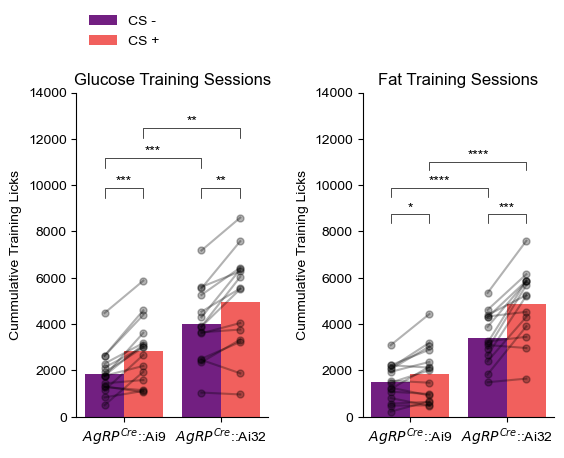

In [23]:
# get cummulative training licks for stim and control mice
# glucose
cumm = df_train_g.total_licks.groupby(['Chr2','mouse','CS']).sum()
sg = cumm.loc[True,].to_frame()
cg =  cumm.loc[False,].to_frame()

# fat
cumm = df_train_f.total_licks.groupby(['Chr2','mouse','CS']).sum()
sf = cumm.loc[True,].to_frame()
cf =  cumm.loc[False,].to_frame()


# create subplot
fig, ax = plt.subplots(1,2, figsize = (6,5))
_, stats_g_cumm= two_bottle_plot(sg,cg, ax = ax[0])
_, stats_f_cumm = two_bottle_plot(sf,cf, ax = ax[1])

#reformat legends
ax[0].legend(ax[0].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)
ax[1].get_legend().remove()


#make sure the y limit is the same
ylim = 14000
ax[0].set_ylim(0,ylim)
ax[1].set_ylim(0,ylim)

# label axes and add titles
ax[0].set_title("Glucose Training Sessions")
ax[0].set_ylabel("Cummulative Training Licks")
ax[1].set_title("Fat Training Sessions")
ax[1].set_ylabel("Cummulative Training Licks")

fig.tight_layout(pad = 2.)
fig.savefig(fig_save_loc/'pdfs'/'supp_fig1_cumm_train_licks.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig1_cumm_train_licks.svg', transparent=True, bbox_inches='tight')

#### stats

In [24]:
supp_fig1_stats = {}

##### stats - glucose unlimited intake cummulative training licks stats

In [25]:
df = pd.concat({True: sg['total_licks'], False: cg['total_licks']}, names = ['Chr2']).rename("total_licks").reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
cumm_train_anova_g = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', dv = 'total_licks', subject = 'mouse', correction = True)
cumm_train_anova_g = cumm_train_anova_g.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_g['Significance'] = cumm_train_anova_g['p-value'].apply(check_significance)
stats_g_cumm = stats_g_cumm.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_g_cumm['Significance'] = stats_g_cumm['Corrected p-value'].apply(check_significance)


display(shapiro, levene, cumm_train_anova_g , stats_g_cumm)
supp_fig1_stats.update({'a_cumm_train_anova_g'   : cumm_train_anova_g,
                        'a_cumm_train_posthoc_g' : stats_g_cumm})

statistic   p-value
Chr2  CS                     
False +    0.944635  0.444228
      -    0.897411  0.086898
True  +    0.967637  0.843553
      -    0.979249  0.970224

,statistic,p-value
CS,,
+,2.380623,0.134489
-,3.117155,0.088780


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,6.579632e+07,1,27,6.579632e+07,14.058458,8.553937e-04,0.342401,NaN,***
1,CS,1.385826e+07,1,27,1.385826e+07,45.376332,3.118576e-07,0.626950,1.0,****
2,Interaction,2.189400e+02,1,27,2.189400e+02,0.000717,9.788364e-01,0.000027,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,4.408576,0.000706,0.001412,13,True,**
CS+ vs. CS- $AgRP^{Cre}$::Ai9,5.164125,0.000144,0.000575,14,True,***
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,3.125205,0.004928,0.004928,27,False,**
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,4.311860,0.000314,0.000942,27,False,***


##### stats - fat unlimited intake cummulative training licks stats

In [26]:
df = pd.concat({True: sf['total_licks'], False: cf['total_licks']}, names = ['Chr2']).rename("total_licks").reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
cumm_train_anova_f = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', dv = 'total_licks', subject = 'mouse', correction = True)
cumm_train_anova_f = cumm_train_anova_f.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_f['Significance'] = cumm_train_anova_f['p-value'].apply(check_significance)
stats_f_cumm = stats_f_cumm.rename(columns = {'statistic': 't', 'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value'})
stats_f_cumm['Significance'] = stats_f_cumm['Corrected p-value'].apply(check_significance)



display(shapiro, levene, cumm_train_anova_f, stats_f_cumm)
supp_fig1_stats.update({'b_cumm_train_anova_f'   : cumm_train_anova_f,
                        'b_cumm_train_posthoc_f': stats_f_cumm})

statistic   p-value
Chr2  CS                     
False +    0.923157  0.215169
      -    0.970161  0.860440
True  +    0.962867  0.769885
      -    0.972843  0.912204

,statistic,p-value
CS,,
+,0.35734,0.554969
-,1.55707,0.222809


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,8.848175e+07,1,27,8.848175e+07,36.042931,0.000002,0.571720,NaN,****
1,CS,1.185325e+07,1,27,1.185325e+07,35.853890,0.000002,0.570432,1.0,****
2,Interaction,4.378342e+06,1,27,4.378342e+06,13.243677,0.001140,0.329087,NaN,**


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,5.379634,0.000125,0.000251,13,True,***
CS+ vs. CS- $AgRP^{Cre}$::Ai9,2.636659,0.019531,0.019531,14,True,*
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,5.909480,0.000004,0.000016,27,False,****
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,5.313762,0.000021,0.000062,27,False,****


In [27]:
with pd.ExcelWriter(stat_save_loc/'supp_figure1.xlsx') as writer:  
    for k,v in supp_fig1_stats.items():
        v.to_excel(writer, sheet_name=k)

## Supplemental Figure 2 - validation of lick burst preference index

In [28]:
# compute lick burst number, average across days and format for model fitting
# glucose
_, bn = lick_microstructure(dft_test_g, 60)
burst_g_mn = bn.burst_num.unstack('CS').groupby(['Chr2','sex','mouse']).sum()
test_licks_g = (df_test_g.set_index('sex', append = True)
                         .total_licks
                         .unstack('CS')
                         .groupby(['Chr2','sex','mouse'])
                         .mean())
train_licks_g = (df_train_g.set_index('sex', append = True)
                           .total_licks
                           .unstack('CS')
                           .groupby(['Chr2','sex','mouse'])
                           .mean())
gb = pd.DataFrame({'tot' : burst_g_mn['+'] + burst_g_mn['-'],
                   'pref':  burst_g_mn['+']/(burst_g_mn['+'] + burst_g_mn['-']),
                   'csp_test'   : test_licks_g['+'],
                   'csm_test'   : test_licks_g['-'],
                   'csp_train'  : train_licks_g['+'],
                   'csm_train'  : train_licks_g['-']})
gb = gb.reset_index().dropna()
gb['stim'] = gb.Chr2.replace({True: r'$AgRP^{Cre}$::Ai32', False: r'$AgRP^{Cre}$::Ai9'})
gb['cond_sex'] = gb.stim + ' ' + gb.sex

# fat
_, bnf = lick_microstructure(dft_test_f, 60)
burst_f_mn = bnf.burst_num.unstack('CS').groupby(['Chr2','sex','mouse']).sum()
test_licks_f = (df_test_f.set_index('sex', append = True)
                         .total_licks
                         .unstack('CS')
                         .groupby(['Chr2','sex','mouse'])
                         .mean())
train_licks_f = (df_train_f.set_index('sex', append = True)
                           .total_licks
                           .unstack('CS')
                           .groupby(['Chr2','sex','mouse'])
                           .mean())
fb = pd.DataFrame({'tot' : burst_f_mn['+'] + burst_f_mn['-'],
                   'pref':  burst_f_mn['+']/(burst_f_mn['+'] + burst_f_mn['-']),
                   'csp_test'   : test_licks_f['+'],
                   'csm_test'   : test_licks_f['-'],
                   'csp_train'  : train_licks_f['+'],
                   'csm_train'  : train_licks_f['-']})
fb = fb.reset_index().dropna()
fb['stim'] = fb.Chr2.replace({True: r'$AgRP^{Cre}$::Ai32', False: r'$AgRP^{Cre}$::Ai9'})
fb['cond_sex'] = fb.stim + ' ' + fb.sex

### main plot

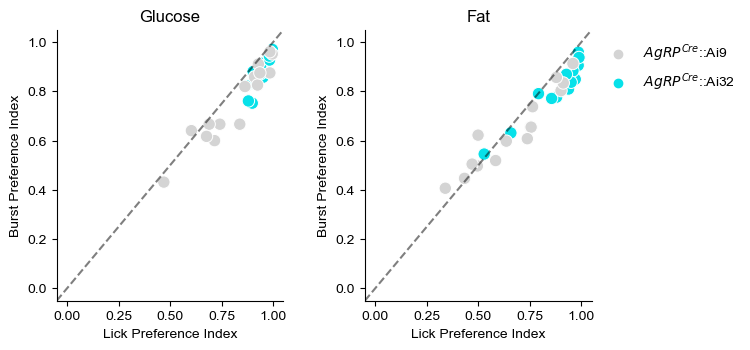

In [29]:
# create the subplot
fig, ax = plt.subplots(1,2, figsize = (8,4))

pref_g_burst = (bn.groupby(['Chr2', 'mouse','CS'])
                  .burst_num
                  .sum()
                  .unstack('CS')
                  .apply(lambda x: pd.Series({'pref': x["+"]/(x["+"] + x["-"]),
                                              'tot': x["+"] + x["-"]}), axis=1)
                  .reset_index()
               )
pref_g_burst['Condition'] = pref_g_burst.Chr2.replace({False: r"$AgRP^{Cre}$::Ai9", True: r"$AgRP^{Cre}$::Ai32"})
pref_g_burst = pref_g_burst.set_index(["Condition","mouse"])

pref_f_burst = (bnf.groupby(['Chr2', 'mouse','CS'])
                   .burst_num
                   .sum()
                   .unstack('CS')
                   .apply(lambda x: pd.Series({'pref': x["+"]/(x["+"] + x["-"]),
                                               'tot': x["+"] + x["-"]}), axis=1)
                   .reset_index()
               )
pref_f_burst['Condition'] = pref_f_burst.Chr2.replace({False: r"$AgRP^{Cre}$::Ai9", True: r"$AgRP^{Cre}$::Ai32"})
pref_f_burst = pref_f_burst.set_index(["Condition","mouse"])


# plot preference index computed from bursts vs those computed from licks
pref_g_comb = pd.concat({'Lick Preference Index': pref_g.pref, 
                        'Burst Preference Index': pref_g_burst.pref}, axis=1)
pref_f_comb = pd.concat({'Lick Preference Index': pref_f.pref, 
                        'Burst Preference Index': pref_f_burst.pref}, axis=1)
sns.scatterplot(data = pref_g_comb.reset_index(), x = 'Lick Preference Index', 
                y = 'Burst Preference Index', hue = 'Condition', 
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'],
                s = 80, palette = [ctl_col, stim_col], ax = ax[0], legend = False) 
sns.scatterplot(data = pref_f_comb.reset_index(), x = 'Lick Preference Index',
                y = 'Burst Preference Index', hue = 'Condition', 
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'],
                s = 80, palette = [ctl_col, stim_col], ax = ax[1]) 

# plot the diagonal
ax[0].plot([-.05,1.05],[-.05,1.05], ls = '--', c = 'k', alpha=.5)
ax[0].set_xlim([-.05,1.05])
ax[0].set_ylim([-.05,1.05])
ax[0].set_title('Glucose')

ax[1].plot([-.05,1.05],[-.05,1.05], ls = '--', c = 'k', alpha=.5)
ax[1].set_xlim([-.05,1.05])
ax[1].set_ylim([-.05,1.05])
ax[1].set_title('Fat')

# format legend text
ax[1].legend(loc = 'upper left', bbox_to_anchor = (1,1), frameon = False, title = "")

# remove bottom roww legends
sns.despine()
fig.tight_layout(pad=2.5)


fig.savefig(fig_save_loc/'pdfs'/'supp_fig2_burst_pref_val.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig2_burst_pref_val.svg', transparent=True, bbox_inches='tight')

#### stats

In [30]:
supp_fig2_stats = {}

##### stats - unlimited inntake lick burst preference vs lick preference stats

In [31]:
g_corr_stats = pd.DataFrame({'Signed Rank Test': st.wilcoxon(pref_g.pref, pref_g_burst.pref),
                             'Spearman Correlation': st.spearmanr(pref_g.pref, pref_g_burst.pref)},
                             index =  ('statistic', 'p-value')).T
g_corr_stats['Significance'] = g_corr_stats['p-value'].apply(check_significance)

f_corr_stats = pd.DataFrame({'Signed Rank': st.wilcoxon(pref_f.pref, pref_f_burst.pref),
                              'Spearman Correlation': st.spearmanr(pref_f.pref, pref_f_burst.pref)},
                              index =  ('statistic', 'p-value')).T
f_corr_stats['Significance'] = f_corr_stats['p-value'].apply(check_significance)

display( g_corr_stats, f_corr_stats)
supp_fig2_stats.update({"a_lick_pref_burst_pref_corr_g": g_corr_stats, 
                        "b_lick_pref_burst_pref_corr_f": f_corr_stats})

,statistic,p-value,Significance
Signed Rank Test,137.000000,0.083676,ns
Spearman Correlation,-0.243253,0.203537,ns


,statistic,p-value,Significance
Signed Rank,179.000000,0.416920,ns
Spearman Correlation,-0.272414,0.152813,ns


In [32]:
with pd.ExcelWriter(stat_save_loc/'supp_figure2.xlsx') as writer:  
    for k,v in supp_fig2_stats.items():
        v.to_excel(writer, sheet_name=k)

## Figure 2 - training v testing correlation

In [33]:
fig2_stats = {}

### model fitting
#### glucose

,VIF Factor,features
0,10.400683,Intercept
1,6.033268,C(Chr2)[T.True]
2,4.432433,csp_train
3,12.655538,C(Chr2)[T.True]:csp_train


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.2086,0.137,1.524,1.275061e-01,-0.060,0.477,ns
C(Chr2)[T.True],1.6496,0.239,6.893,5.471375e-12,1.181,2.119,****
csp_train,0.0012,0.000,8.659,4.769866e-18,0.001,0.001,****
C(Chr2)[T.True]:csp_train,-0.0012,0.000,-6.845,7.628942e-12,-0.002,-0.001,****


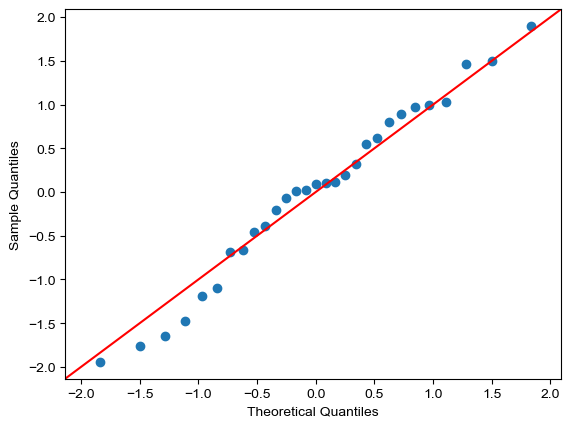

In [34]:
model_eq = 'pref ~ (C(Chr2))*csp_train'
y, X = dmatrices(model_eq, gb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)

model_gb = smf.glm(model_eq, data = gb, 
                   family = sm.families.Binomial(), freq_weights = gb.tot).fit()
model_gb_summ =pd.DataFrame(model_gb.summary().tables[1])
model_gb_summ.columns = model_gb_summ.iloc[0].astype(str)
model_gb_summ = model_gb_summ.astype(str).set_index('').iloc[1:].astype(float)
model_gb_summ['P>|z|'] = model_gb.pvalues
model_gb_summ['Significance'] = model_gb_summ['P>|z|'].apply(check_significance)
model_gb_pseudo_r2 = pd.DataFrame({"R2":model_gb.pseudo_rsquared()}, index=("Cox-Snell R2",))

display(model_gb_summ)
sm.qqplot(model_gb.resid_deviance, fit=True, line='45');
fig2_stats.update({'c_train_v_test_glm_g': model_gb_summ,
                   'c_train_v_test_glm_r2': model_gb_pseudo_r2 })

#### alternate glucose model

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,1.858200e+00,0.196,9.466,0.000,1.473,2.243,****
csp_train,6.313000e-07,0.000,0.006,0.995,-0.000,0.000,ns


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.2086,0.137,1.524,0.128,-0.060,0.477,ns
csp_train,0.0012,0.000,8.659,0.000,0.001,0.001,****


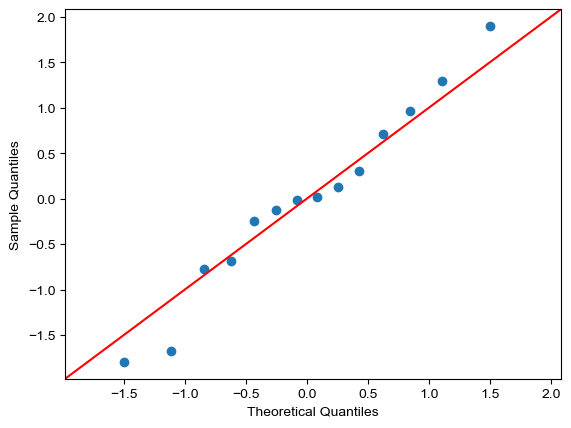

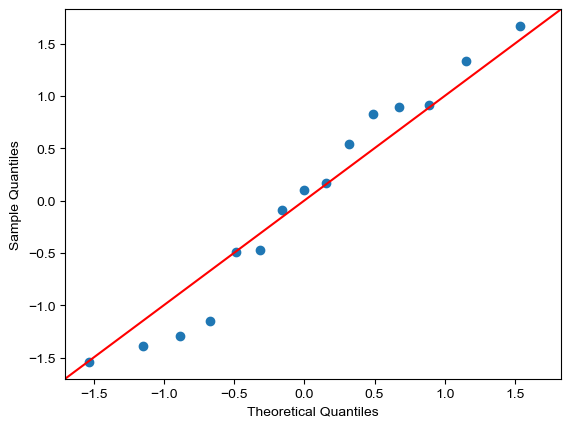

In [35]:
model_eq = 'pref ~ 1 + csp_train'

model_gb_stim = smf.glm(model_eq, data = gb.loc[gb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = gb.loc[gb.Chr2].tot).fit()
model_gb_stim_summ =pd.DataFrame(model_gb_stim.summary().tables[1])
model_gb_stim_summ.columns = model_gb_stim_summ.iloc[0].astype(str)
model_gb_stim_summ = model_gb_stim_summ.set_index('').iloc[1:].astype(str).astype(float)
model_gb_stim_summ['Significance'] = model_gb_stim_summ['P>|z|'].apply(check_significance)
model_gb_stim_pseudo_r2 = pd.DataFrame({"R2": model_gb_stim.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gb_stim.resid_deviance, fit=True, line='45');



model_gb_ctl = smf.glm(model_eq, data = gb.loc[~gb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = gb.loc[~gb.Chr2].tot).fit()
model_gb_ctl_summ =pd.DataFrame(model_gb_ctl.summary().tables[1])
model_gb_ctl_summ.columns = model_gb_ctl_summ.iloc[0].astype(str)
model_gb_ctl_summ = model_gb_ctl_summ.set_index('').iloc[1:].astype(str).astype(float)
model_gb_ctl_summ['Significance'] = model_gb_ctl_summ['P>|z|'].apply(check_significance)
model_gb_ctl_pseudo_r2 = pd.DataFrame({"R2": model_gb_ctl.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_gb_ctl.resid_deviance, fit=True, line='45');


display(model_gb_stim_summ, model_gb_ctl_summ)


fig2_stats.update({'c_train_v_test_glm_stim_g': model_gb_stim_summ,
                   'c_train_v_test_glm_stim_g_r2': model_gb_stim_pseudo_r2 ,
                   'c_train_v_test_glm_ctl_g': model_gb_ctl_summ,
                   'c_train_v_test_glm_ctl_g_r2': model_gb_ctl_pseudo_r2 })

#### fat

,VIF Factor,features
0,6.964811,Intercept
1,7.927447,C(Chr2)[T.True]
2,5.860516,csp_train
3,16.879001,C(Chr2)[T.True]:csp_train


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.0625,0.09,0.691,0.489,-0.115,0.240,ns
C(Chr2)[T.True],0.4462,0.19,2.354,0.019,0.075,0.818,*
csp_train,0.0011,0.00,8.276,0.000,0.001,0.001,****
C(Chr2)[T.True]:csp_train,-0.0005,0.00,-3.090,0.002,-0.001,-0.000,**


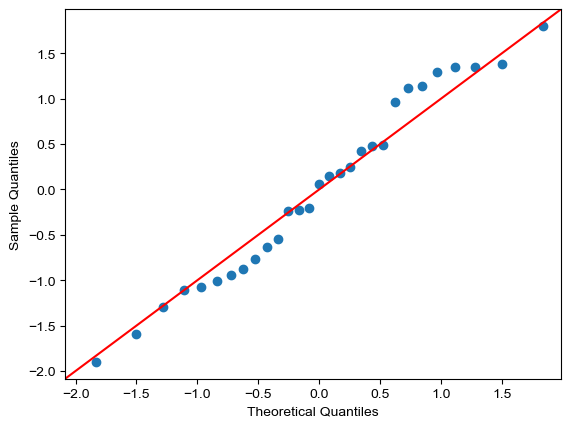

In [36]:
model_eq = 'pref ~ (C(Chr2))*csp_train'
y, X = dmatrices(model_eq, fb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)
model_fb = smf.glm(model_eq, data = fb, 
                family = sm.families.Binomial(), freq_weights = fb.tot).fit()
model_fb_summ =pd.DataFrame(model_fb.summary().tables[1])
model_fb_summ.columns = model_fb_summ.iloc[0].astype(str)
model_fb_summ = model_fb_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_summ['Significance'] = model_fb_summ['P>|z|'].apply(check_significance)
model_fb_pseudo_r2 = pd.DataFrame({"R2":model_fb.pseudo_rsquared()}, index=("Cox-Snell R2",))

display(model_fb_summ)
sm.qqplot(model_fb.resid_deviance, fit=True, line='45');
fig2_stats.update({'f_train_v_test_glm_f': model_fb_summ,
                   'f_train_v_test_glm_f_r2': model_fb_pseudo_r2 })

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.5087,0.167,3.053,0.002,0.182,0.835,**
csp_train,0.0006,0.000,5.274,0.000,0.000,0.001,****


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.1408,0.104,1.349,0.177,-0.064,0.345,ns
csp_train,0.0011,0.000,7.320,0.000,0.001,0.001,****


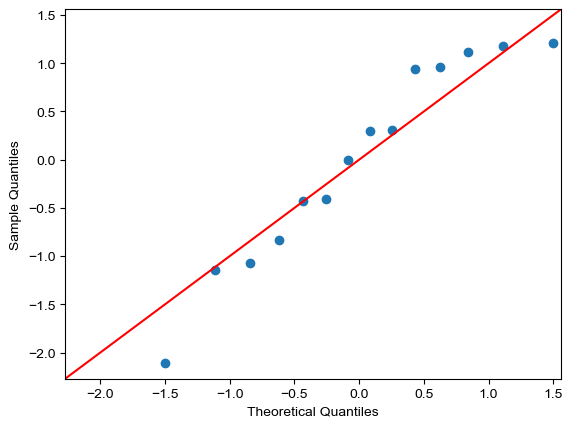

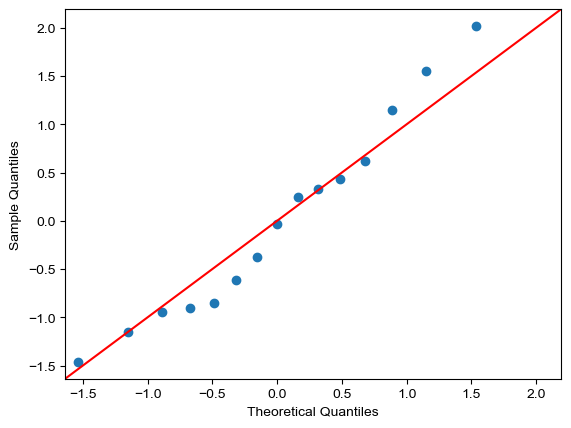

In [37]:
model_eq = 'pref ~ 1 + csp_train'

model_fb_stim = smf.glm(model_eq, data = fb.loc[fb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = fb.loc[fb.Chr2].tot).fit()
model_fb_stim_summ =pd.DataFrame(model_fb_stim.summary().tables[1])
model_fb_stim_summ.columns = model_fb_stim_summ.iloc[0].astype(str)
model_fb_stim_summ = model_fb_stim_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_stim_pseudo_r2 = pd.DataFrame({"R2": model_fb_stim.pseudo_rsquared()}, index=("Cox-Snell R2",))
model_fb_stim_summ['Significance'] = model_fb_stim_summ['P>|z|'].apply(check_significance)
sm.qqplot(model_fb_stim.resid_deviance, fit=True, line='45');



model_fb_ctl = smf.glm(model_eq, data = fb.loc[~fb.Chr2], 
                        family = sm.families.Binomial(), 
                        freq_weights = gb.loc[~fb.Chr2].tot).fit()
model_fb_ctl_summ =pd.DataFrame(model_fb_ctl.summary().tables[1])
model_fb_ctl_summ.columns = model_fb_ctl_summ.iloc[0].astype(str)
model_fb_ctl_summ = model_fb_ctl_summ.set_index('').iloc[1:].astype(str).astype(float)
model_fb_ctl_summ['Significance'] = model_fb_ctl_summ['P>|z|'].apply(check_significance)
model_fb_ctl_pseudo_r2 = pd.DataFrame({"R2": model_fb_ctl.pseudo_rsquared()}, index=("Cox-Snell R2",))
sm.qqplot(model_fb_ctl.resid_deviance, fit=True, line='45');


display(model_fb_stim_summ, model_fb_ctl_summ)


fig2_stats.update({'f_train_v_test_glm_stim_f': model_fb_stim_summ,
                   'f_train_v_test_glm_stim_f_r2': model_fb_stim_pseudo_r2 ,
                   'f_train_v_test_glm_ctl_f': model_fb_ctl_summ,
                   'f_train_v_test_glm_ctl_f_r2': model_fb_ctl_pseudo_r2 })

### main plots - correlations

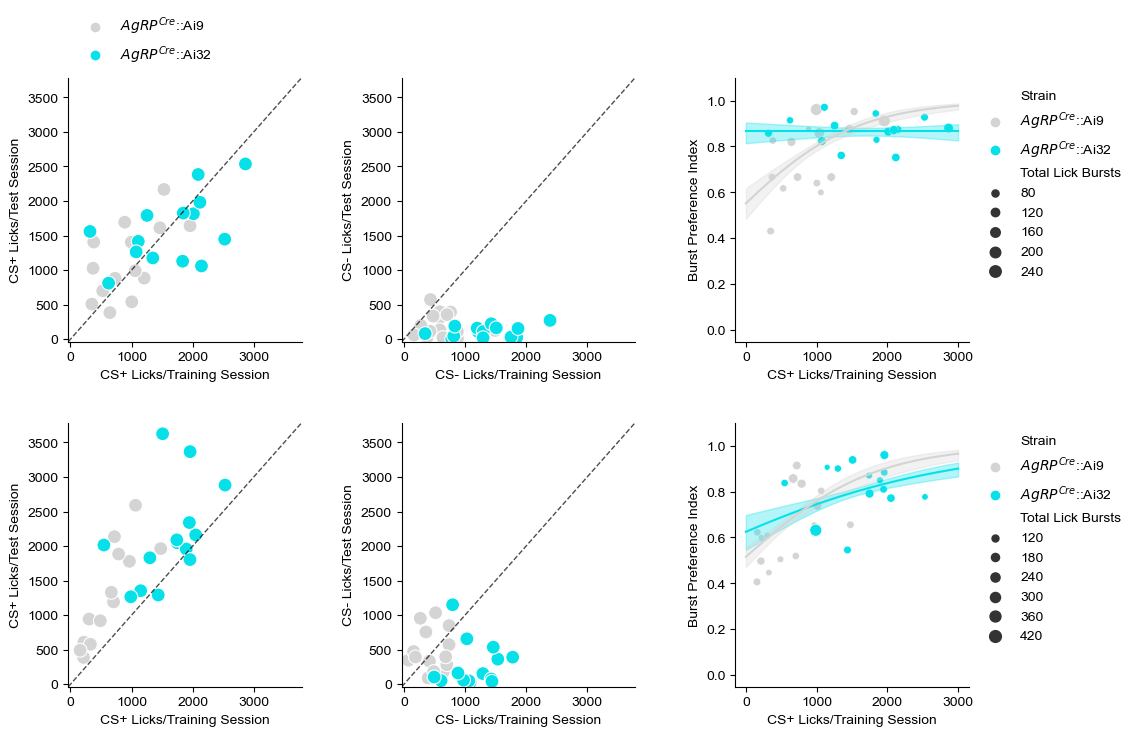

In [38]:
# create the subplot
fig, ax = plt.subplots(2, 3, figsize = (12,8))

# plot testing vs training licks for CS+ and CS-
# glucose
sns.scatterplot(data =gb, x='csp_train', y= 'csp_test', hue='stim', 
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'],
                palette = [ ctl_col, stim_col], s=100, ax=ax[0,0]);
sns.scatterplot(data = gb, x='csm_train', y= 'csm_test', hue='stim', 
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'], 
                legend = False, palette = [ ctl_col, stim_col], s=100, ax=ax[0,1]);
# fat
sns.scatterplot(data = fb, x='csp_train', y= 'csp_test', hue='stim', 
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'],
                legend = False, palette = [ ctl_col, stim_col], s=100, ax=ax[1,0]);
sns.scatterplot(data = fb, x='csm_train', y= 'csm_test', hue='stim',
                hue_order = [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'],
                legend = False, palette = [ ctl_col, stim_col], s=100, ax=ax[1,1]);
ax[0,0].legend(loc = 'lower left', bbox_to_anchor = (0,1), frameon = False, title = "")

# determine common x and y limits for all plots
xlims = np.array([ ax[i,j].get_xlim() for i in range(2) for j in range(2)])
ylims = np.array([ ax[i,j].get_ylim() for i in range(2) for j in range(2)])
lims = np.concatenate((xlims, ylims), axis=0)
bnd = (lims[:,0].min(), lims[:,1].max())


# plot the diagonal for scatter plots
ax[0,0].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)
ax[0,1].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)
ax[1,0].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)
ax[1,1].plot(bnd, bnd, c = 'k', ls = '--', alpha = .7, lw = 1)

# plot preference vs training licks
sns.scatterplot(data = gb.rename(columns={'tot': 'Total Lick Bursts', 'stim': 'Strain'}),
                x='csp_train', y= 'pref', hue='Strain', legend = True, size='Total Lick Bursts',
                palette = [ ctl_col, stim_col], s=100, ax=ax[0,2]);
sns.move_legend(ax[0,2], loc='upper left', bbox_to_anchor = (1,1), frameon = False)
sns.scatterplot(data = fb.rename(columns={'tot': 'Total Lick Bursts', 'stim': 'Strain'}), 
                x='csp_train', y= 'pref', hue='Strain', legend = True, size='Total Lick Bursts',
                palette = [ ctl_col, stim_col], s=100, ax=ax[1,2]);
sns.move_legend(ax[1,2], loc='upper left', bbox_to_anchor = (1,1), frameon = False)


# get model predictions separately for stim and control mice
x = np.linspace(0,3000,1000) # test values
# glucose
pred_stim_g = model_gb.get_prediction({'Chr2': [True]*x.size, 'csp_train': x})
pred_ctl_g = model_gb.get_prediction({'Chr2': [False]*x.size, 'csp_train': x})
# fat
pred_stim_f = model_fb.get_prediction({'Chr2': [True]*x.size, 'csp_train': x})
pred_ctl_f= model_fb.get_prediction({'Chr2': [False]*x.size, 'csp_train': x})

# plot the model predictions
# glucose
ax[0,2].plot(x, pred_stim_g.predicted_mean, c=stim_col)
ax[0,2].fill_between(x, pred_stim_g.conf_int()[:,0], 
                     pred_stim_g.conf_int()[:,1], 
                     alpha=.3, color = stim_col)
ax[0,2].plot(x,  pred_ctl_g.predicted_mean, c =ctl_col)
ax[0,2].fill_between(x, pred_ctl_g.conf_int()[:,0], 
                     pred_ctl_g.conf_int()[:,1], 
                     alpha=.3,color=ctl_col)
# fat
ax[1,2].plot(x, pred_stim_f.predicted_mean, c=stim_col)
ax[1,2].fill_between(x, pred_stim_f.conf_int()[:,0], 
                     pred_stim_f.conf_int()[:,1], 
                     alpha=.3, color = stim_col)
ax[1,2].plot(x,  pred_ctl_f.predicted_mean, c =ctl_col)
ax[1,2].fill_between(x, pred_ctl_f.conf_int()[:,0], 
                     pred_ctl_f.conf_int()[:,1], 
                     alpha=.3,color=ctl_col)


# label axes and set the axis limits
ax[0,0].set(ylabel = "CS+ Licks/Test Session", 
            xlabel = "CS+ Licks/Training Session",
            xlim  = bnd, ylim = bnd)
ax[0,1].set(ylabel = "CS- Licks/Test Session", 
            xlabel = "CS- Licks/Training Session",
            xlim  = bnd, ylim = bnd)
ax[1,0].set(ylabel = "CS+ Licks/Test Session", 
            xlabel = "CS+ Licks/Training Session",
            xlim  = bnd, ylim = bnd)
ax[1,1].set(ylabel = "CS- Licks/Test Session", 
            xlabel = "CS- Licks/Training Session",
            xlim  = bnd, ylim = bnd)
ax[0,2].set(xlabel = 'CS+ Licks/Training Session',
            ylabel = 'Burst Preference Index',
            ylim = (-.05,1.1))
ax[1,2].set(xlabel = 'CS+ Licks/Training Session',
          ylabel = 'Burst Preference Index',
          ylim = (-.05,1.1))

# format plots
sns.despine()
fig.tight_layout(pad = 3.)

#save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig2_corr.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig2_corr.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - glucose unlimited intake training vs testing licks correlation

In [39]:
r_csp, p_csp = st.pearsonr(gb['csp_train'], gb['csp_test'])
r_csm, p_csm = st.pearsonr(gb['csm_train'], gb['csm_test'])
corr_g_p = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csp, p_csp, check_significance(p_csp)]},
                      index = ('Pearson R', 'p-value', 'Significance')).T

corr_g_m = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csm, p_csm, check_significance(p_csm)]} ,
                      index = ('Pearson R', 'p-value', 'Significance')).T

display(corr_g_p, corr_g_m )
fig2_stats.update({'a_train_v_test_corr_g_csp': corr_g_p,
                   'b_train_v_test_corr_g_csm': corr_g_m,})

,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,0.636017,0.000209,***


,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,-0.159379,0.408902,ns


##### stats - fat unlimited intake training vs testing licks correlation

In [40]:
r_csp, p_csp = st.pearsonr(fb['csp_train'], fb['csp_test'])
r_csm, p_csm = st.pearsonr(fb['csm_train'], fb['csm_test'])
corr_f_p = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csp, p_csp, check_significance(p_csp)]},
                      index = ('Pearson R', 'p-value', 'Significance')).T

corr_f_m = pd.DataFrame({'Training vs Testing CS+ Licks': [r_csm, p_csm, check_significance(p_csm)]} ,
                      index = ('Pearson R', 'p-value', 'Significance')).T

display(corr_f_p, corr_f_m )
fig2_stats.update({'d_train_v_test_corr_g_csp': corr_f_p,
                   'e_train_v_test_corr_g_csm': corr_f_m})

,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,0.757673,0.000002,****


,Pearson R,p-value,Significance
Training vs Testing CS+ Licks,-0.223758,0.243276,ns


### sex differences

#### Check for multicollinearity
We want to include a term for sex in our models to determine whether or not there are sex differences but before doing so we need to make sure sex is not severely multicollinear with other variables in the model. We'll use the VIF to address this as we did above

#### glucose

In [41]:
model_eq = 'pref ~ C(Chr2)*C(sex)*csp_train -  C(Chr2):C(sex):csp_train'
y, X = dmatrices(model_eq, gb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)

,VIF Factor,features
0,20.183722,Intercept
1,7.837144,C(Chr2)[T.True]
2,8.013035,C(sex)[T.M]
3,12.134364,C(Chr2)[T.True]:C(sex)[T.M]
4,13.842537,csp_train
5,28.354615,C(Chr2)[T.True]:csp_train
6,30.149166,C(sex)[T.M]:csp_train


#### fat

In [42]:
model_eq = 'pref ~ C(Chr2)*C(sex)*csp_train -  C(Chr2):C(sex):csp_train'
y, X = dmatrices(model_eq, fb, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
display(vif)

,VIF Factor,features
0,11.146011,Intercept
1,9.816158,C(Chr2)[T.True]
2,4.863911,C(sex)[T.M]
3,11.860784,C(Chr2)[T.True]:C(sex)[T.M]
4,7.867472,csp_train
5,22.403584,C(Chr2)[T.True]:csp_train
6,21.140292,C(sex)[T.M]:csp_train


### main plot - sex differences

/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1585498484.py:333: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


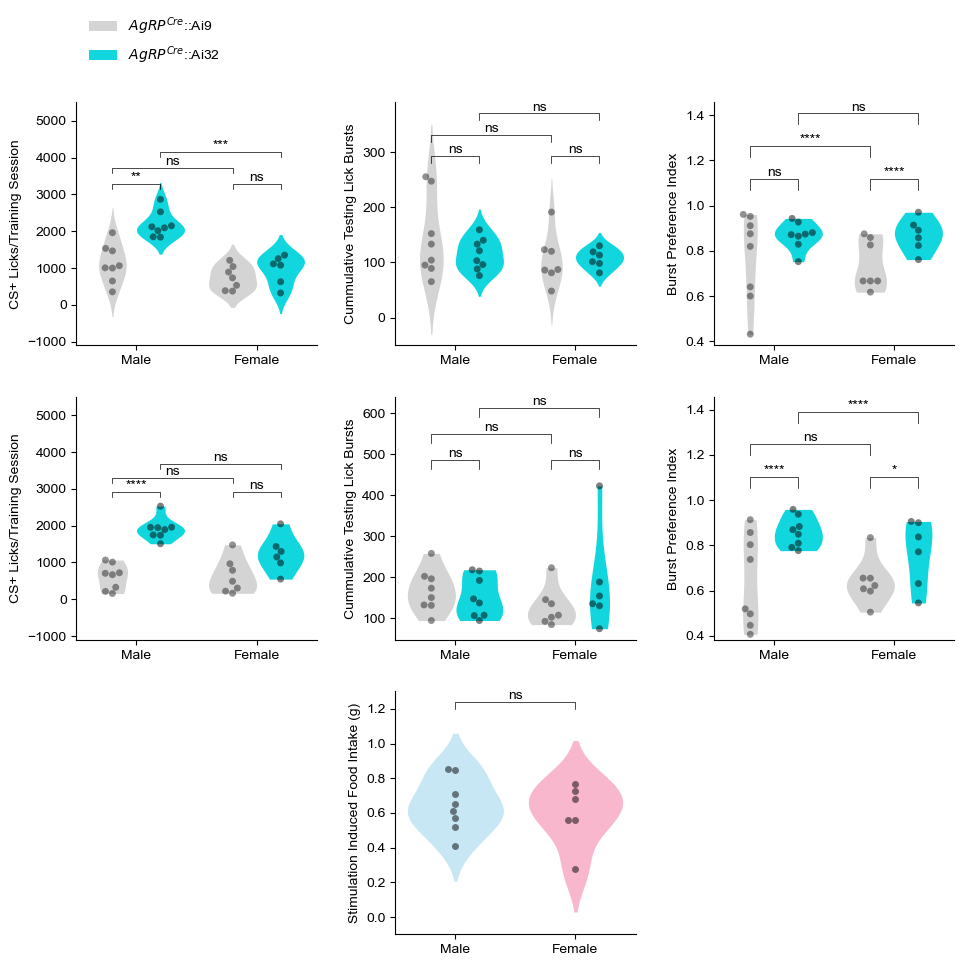

In [43]:
# create subplot
fig, ax = plt.subplots(3,3, figsize = (10,10))

# glucose
# plot training licks split by strain and sex
sns.violinplot(data =gb, x = 'sex', y = 'csp_train', hue = 'Chr2', 
               saturation = .9, order = ['M','F'], hue_order=[False,True],
               linewidth = 0, palette = [ctl_col, stim_col], ax = ax[0,0])
# get legend handles for violin plot so we only keep these in the legend
handles, labels = ax[0,0].get_legend_handles_labels() 
sns.swarmplot(data = gb, x = 'sex', y = 'csp_train', hue = 'Chr2', 
              order = ['M','F'], hue_order=[False,True],
              dodge = True, color = 'k', alpha = .5,  ax = ax[0,0])
ax[0,0].legend(handles, [r'$AgRP^{Cre}$::Ai9', r'$AgRP^{Cre}$::Ai32'], loc = 'lower left', 
             frameon = False, bbox_to_anchor=(0,1.1))
ax[0,0].set_xticklabels(["Male", "Female"])
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("CS+ Licks/Training Session")


# compute stats
sex_comp = (gb.set_index(['Chr2','sex','mouse']).groupby('Chr2').csp_train
              .apply(lambda x: st.ttest_ind(x.loc[:,'M'], x.loc[:,'F'], equal_var = False))
              .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
           )
stim_comp = (gb.set_index(['Chr2','sex','mouse']).groupby('sex').csp_train
               .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = False))
               .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
            )

train_sex_diff_stats = pd.concat({'Male vs Female': sex_comp.reset_index(), 
                                       'Stim vs Control': stim_comp.reset_index()},
                                      names = ['comparison']).droplevel(1).reset_index()
train_sex_diff_stats['Corrected p-value'] = multipletests(train_sex_diff_stats['p-value'], method = 'holm-sidak')[1]
pcorr = train_sex_diff_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=gb.csp_train.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[0,0], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[0,0], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[0,0], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[0,0], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)


# plot total test licks by strain and sex
sns.swarmplot(gb, x='sex', y='tot', hue = 'Chr2',
              order = ['M','F'], hue_order = [False, True],
              dodge= True,  alpha = .5, palette = 'dark:k', ax=ax[0,1])
sns.violinplot(gb, x='sex', y='tot', hue = 'Chr2', order = ['M','F'], hue_order = [False, True],
               saturation = .9, linewidth = 0, palette = [ctl_col, stim_col],
               ax = ax[0,1])


ax[0,1].get_legend().remove()
ax[0,1].set_xticklabels(['Male', 'Female'])
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("Cummulative Testing Lick Bursts")

# compute stats
sex_comp = (gb.set_index(['Chr2','sex','mouse']).groupby('Chr2').tot
              .apply(lambda x: st.ttest_ind(x.loc[:,'M'], x.loc[:,'F'], equal_var = False))
              .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
           )
stim_comp = (gb.set_index(['Chr2','sex','mouse']).groupby('sex').tot
               .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = False))
               .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
            )

test_sex_diff_stats = pd.concat({'Male vs Female': sex_comp.reset_index(), 
                                 'Stim vs Control': stim_comp.reset_index()},
                                 names = ['comparison']).droplevel(1).reset_index()
test_sex_diff_stats['Corrected p-value'] = multipletests(test_sex_diff_stats['p-value'], method = 'holm-sidak')[1]
pcorr = test_sex_diff_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=gb.tot.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[0,1], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[0,1], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[0,1], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[0,1], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)


# plot preference split by strain and sex
sns.swarmplot(gb, x='sex', y='pref', hue = 'Chr2',
              order = ['M','F'], hue_order = [False, True],
              dodge= True,  alpha = .5, palette = 'dark:k', ax=ax[0,2])
sns.violinplot(gb, x='sex', y='pref', hue = 'Chr2', order = ['M','F'], hue_order = [False, True],
               saturation = .9, linewidth = 0, palette = [ctl_col, stim_col],
               ax = ax[0,2], cut=0)


ax[0,2].get_legend().remove()
ax[0,2].set_xticklabels(['Male', 'Female'])
ax[0,2].set_xlabel("")
ax[0,2].set_ylabel("Burst Preference Index")

# compute stats
sex_comp = (gb.groupby('Chr2')
              .apply(lambda x: smf.glm('pref ~ 1 + sex', data = x, 
                                       family = sm.families.Binomial(), 
                                       freq_weights = x.tot).fit())
              .apply(lambda x:  pd.Series({'coef': x.params['sex[T.M]'], 
                                           't': x.tvalues['sex[T.M]'], 
                                           'p-value': x.pvalues['sex[T.M]']}))
              .reset_index()
)

stim_comp = (gb.groupby('sex')
               .apply(lambda x: smf.glm('pref ~ 1 + Chr2', data = x, 
                                        family = sm.families.Binomial(), 
                                        freq_weights = x.tot).fit())
               .apply(lambda x:  pd.Series({'coef': x.params['Chr2[T.True]'], 
                                             't': x.tvalues['Chr2[T.True]'], 
                                             'p-value': x.pvalues['Chr2[T.True]']}))
               .reset_index()
)

pref_sex_diff_stats = pd.concat({'Male vs Female': sex_comp, 
                                 'Stim vs Control': stim_comp}, 
                                names = ['comparison']).droplevel(1).reset_index()
pref_sex_diff_stats['Corrected p-value'] = multipletests(pref_sex_diff_stats['p-value'], method = 'holm-sidak')[1]
pcorr = pref_sex_diff_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']


# plot the stats
y=gb.pref.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[0,2], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[0,2], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[0,2], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[0,2], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)



# fat
# plot training licks split by strain and sex
sns.swarmplot(fb, x='sex', y='csp_train', hue = 'Chr2',
              hue_order = [False, True], order = ["M", "F"],
              dodge= True,  alpha = .5, palette = 'dark:k', ax=ax[1,0])
sns.violinplot(fb, x='sex', y='csp_train', hue = 'Chr2',
               hue_order = [False, True], order = ["M", "F"],
               saturation = .9, linewidth = 0, palette = [ctl_col, stim_col],
               ax = ax[1,0], cut=0)
ax[1,0].get_legend().remove()
ax[1,0].set_xticklabels(["Male", "Female"])
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("CS+ Licks/Training Session")



# compute stats
sex_comp = (fb.set_index(['Chr2','sex','mouse']).groupby('Chr2').csp_train
              .apply(lambda x: st.ttest_ind(x.loc[:,'M'], x.loc[:,'F'], equal_var = False))
              .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
           )
stim_comp = (fb.set_index(['Chr2','sex','mouse']).groupby('sex').csp_train
               .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = False))
               .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
            )

train_sex_diff_stats_f = pd.concat({'Male vs Female': sex_comp.reset_index(), 
                                    'Stim vs Control': stim_comp.reset_index()},
                                     names = ['comparison']).droplevel(1).reset_index()
train_sex_diff_stats_f['Corrected p-value'] = multipletests(train_sex_diff_stats_f['p-value'], method = 'holm-sidak')[1]
pcorr = train_sex_diff_stats_f.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=fb.csp_train.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[1,0], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[1,0], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[1,0], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[1,0], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)



# plot total test licks split by strain and sex
sns.swarmplot(fb, x='sex', y='tot', hue = 'Chr2',
              hue_order = [False, True], order = ["M", "F"],
              dodge= True,  alpha = .5, palette = 'dark:k', ax=ax[1,1])
sns.violinplot(fb, x='sex', y='tot', hue = 'Chr2',
               hue_order = [False, True], order = ["M", "F"],
               saturation = .9, linewidth = 0, palette = [ctl_col, stim_col],
               ax = ax[1,1], cut=0)


ax[1,1].get_legend().remove()
ax[1,1].set_xticklabels(["Male", "Female"])
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("Cummulative Testing Lick Bursts")



# compute stats
sex_comp = (fb.set_index(['Chr2','sex','mouse']).groupby('Chr2').tot
              .apply(lambda x: st.ttest_ind(x.loc[:,'M'], x.loc[:,'F'], equal_var = False))
              .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
           )
stim_comp = (fb.set_index(['Chr2','sex','mouse']).groupby('sex').tot
               .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = False))
               .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
            )

test_sex_diff_stats_f = pd.concat({'Male vs Female': sex_comp.reset_index(), 
                                 'Stim vs Control': stim_comp.reset_index()},
                                 names = ['comparison']).droplevel(1).reset_index()
test_sex_diff_stats_f['Corrected p-value'] = multipletests(test_sex_diff_stats_f['p-value'], method = 'holm-sidak')[1]
pcorr = test_sex_diff_stats_f.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=fb.tot.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[1,1], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[1,1], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[1,1], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[1,1], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)



# plot preference split by strain and sex
sns.swarmplot(fb, x='sex', y='pref', hue = 'Chr2',
              hue_order = [False, True], order = ["M", "F"],
              dodge= True,  alpha = .5, palette = 'dark:k', ax=ax[1,2])
sns.violinplot(fb, x='sex', y='pref', hue = 'Chr2',
               hue_order = [False, True], order = ["M", "F"],
               saturation = .9, linewidth = 0, palette = [ctl_col, stim_col],
               ax = ax[1,2], cut=0)

ax[1,2].get_legend().remove()
ax[1,2].set_xticklabels(["Male", "Female"])
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("Burst Preference Index")

# compute stats
sex_comp = (fb.groupby('Chr2')
              .apply(lambda x: smf.glm('pref ~ 1 + sex', data = x, 
                                       family = sm.families.Binomial(), 
                                       freq_weights = x.tot).fit())
              .apply(lambda x:  pd.Series({'coef': x.params['sex[T.M]'], 
                                           't': x.tvalues['sex[T.M]'], 
                                           'p-value': x.pvalues['sex[T.M]']}))
              .reset_index()
)

stim_comp = (fb.groupby('sex')
               .apply(lambda x: smf.glm('pref ~ 1 + Chr2', data = x, 
                                        family = sm.families.Binomial(), 
                                        freq_weights = x.tot).fit())
               .apply(lambda x:  pd.Series({'coef': x.params['Chr2[T.True]'], 
                                             't': x.tvalues['Chr2[T.True]'], 
                                             'p-value': x.pvalues['Chr2[T.True]']}))
               .reset_index()
)

pref_sex_diff_stats_f = pd.concat({'Male vs Female': sex_comp, 
                                 'Stim vs Control': stim_comp}, 
                                names = ['comparison']).droplevel(1).reset_index()
pref_sex_diff_stats_f['Corrected p-value'] = multipletests(pref_sex_diff_stats_f['p-value'], method = 'holm-sidak')[1]
pcorr = pref_sex_diff_stats_f.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']


# plot the stats
y=fb.pref.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[1,2], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[1,2], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[1,2], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[1,2], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)



# plot feeding data split by sex
feeding = (pd.read_csv(os.path.join(data_dir,"raw_data/normal_intake/opto_validation.csv"))
             .rename(columns = {'Mouse ': 'mouse'})
             .set_index('mouse'))
feeding['sex'] = df_test_g.loc[True,].sex.unstack(['day','CS']).iloc[:,0]
sns.violinplot(data = feeding, x = 'sex', y = 'stim',  order = ['M','F'],  
               palette = ['#C8E7F5', '#F8B7CD'], saturation = 1., 
               linewidth = 0, ax = ax[2,1])
sns.swarmplot(data = feeding, x = 'sex', y = 'stim', color = 'k', order = ['M','F'],
              alpha = .5, ax = ax[2,1])
ax[2,1].set_ylabel("Stimulation Induced Food Intake (g)")
ax[2,1].set_xlabel("")
ax[2,1].set_xticklabels(["Male", "Female"])

# compute stats
fint_sex_diff = st.ttest_ind(feeding.loc[feeding.sex=='F', 'stim'], 
                             feeding.loc[feeding.sex=='M', 'stim'], 
                             equal_var = False)
fint_sex_diff = pd.DataFrame(fint_sex_diff, index = ['t', 'p-value'], columns = ['ttest']).T

# plot the stats
y = feeding.stim.max()
plot_significance(fint_sex_diff.loc['ttest','p-value'], ax[2,1], x1=0, x2=1, yy= 1.4*y, h=.05*y)


# adjust axis limits
for i in range(3):
    for j in range(3):
        ax[i,j].set_xlim(-.5,1.5)
ax[0,0].set_ylim(-1100, 5500)
ax[1,0].set_ylim(-1100, 5500)
ax[2,1].set_ylim(-.1,1.3)
# ax[0,2].set_ylim(ax[1,2].get_ylim())
ax[1,2].set_ylim(ax[0,2].get_ylim())

ax[2,0].axis('off')
ax[2,2].axis('off')

# format the plots
sns.despine()
fig.tight_layout(pad = 2)
fig.show()


# save the figure
fig.savefig(fig_save_loc/'pdfs'/'fig2_sex_diff.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig2_sex_diff.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - train licks

,sum_sq,df,F,PR(>F),Significance
"C(sex, Sum)",4.473879e+06,1.0,27.073443,0.000022,****
"C(Chr2, Sum)",3.359952e+06,1.0,20.332576,0.000133,***
"C(sex, Sum):C(Chr2, Sum)",1.242175e+06,1.0,7.516958,0.011127,*
Residual,4.131243e+06,25.0,NaN,NaN,ns


,comparison,Chr2,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,1.784885,0.099583,NaN,0.189249,ns
1,Male vs Female,True,5.989366,0.000131,NaN,0.000524,***
2,Stim vs Control,NaN,1.079443,0.306444,F,0.306444,ns
3,Stim vs Control,NaN,4.803606,0.000396,M,0.001188,**


,sum_sq,df,F,PR(>F)
"C(sex, Sum)",6.771580e+05,1.0,4.168204,5.187614e-02
"C(Chr2, Sum)",7.165456e+06,1.0,44.106524,5.857136e-07
"C(sex, Sum):C(Chr2, Sum)",8.422965e+05,1.0,5.184705,3.160684e-02
Residual,4.061449e+06,25.0,NaN,NaN


,comparison,Chr2,t,p-value,sex,Corrected p-value
0,Male vs Female,False,-0.097060,0.924455,NaN,0.924455
1,Male vs Female,True,2.903557,0.020972,NaN,0.061607
2,Stim vs Control,NaN,2.259667,0.046159,F,0.090187
3,Stim vs Control,NaN,8.111882,0.000001,M,0.000006


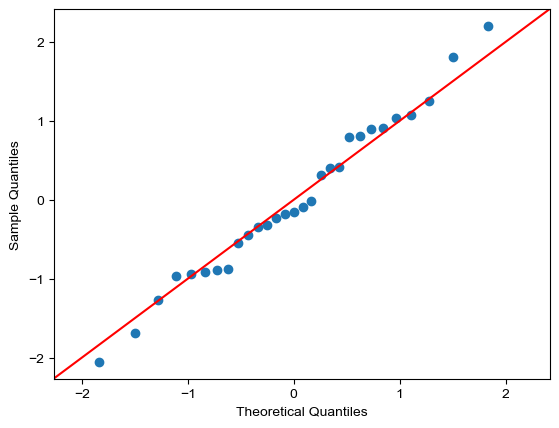

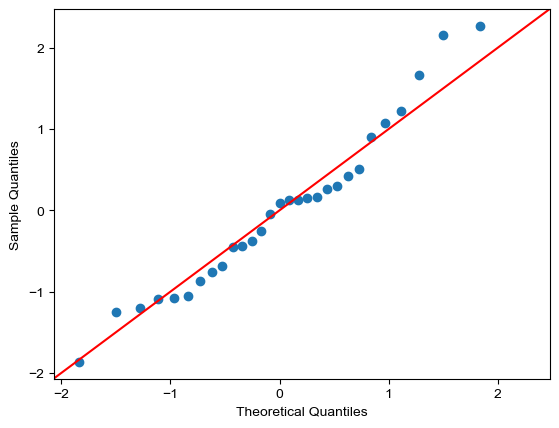

In [44]:
model = smf.ols('csp_train ~ C(sex, Sum)*C(Chr2, Sum)', data=gb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_train_sex_diff = sm.stats.anova_lm(model, typ=2)
anova_train_sex_diff['Significance'] = anova_train_sex_diff['PR(>F)'].apply(check_significance)
train_sex_diff_stats['Significance'] = train_sex_diff_stats['Corrected p-value'].apply(check_significance)


model = smf.ols('csp_train ~ C(sex, Sum)*C(Chr2, Sum)', data=fb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_train_sex_diff_f = sm.stats.anova_lm(model, typ=2)
anova_train_sex_diff['Significance'] = anova_train_sex_diff['PR(>F)'].apply(check_significance)
train_sex_diff_stats['Significance'] = train_sex_diff_stats['Corrected p-value'].apply(check_significance)


display(anova_train_sex_diff,  train_sex_diff_stats, anova_train_sex_diff_f, train_sex_diff_stats_f)
fig2_stats.update({'g_anova_train_licks_sex_diff': anova_train_sex_diff,
                   'g_train_licks_sex_diff_stat': train_sex_diff_stats,
                   'j_anova_train_licks_sex_diff_f': anova_train_sex_diff_f,
                   'j_train_licks_sex_diff_stat_f': train_sex_diff_stats_f})

##### stats - total test bursts

,sum_sq,df,F,PR(>F),Significance
"C(sex, Sum)",3809.705370,1.0,1.700918,0.204049,ns
"C(Chr2, Sum)",1553.914894,1.0,0.693776,0.412770,ns
"C(sex, Sum):C(Chr2, Sum)",1593.227964,1.0,0.711328,0.407001,ns
Residual,55994.857143,25.0,NaN,NaN,ns


,comparison,Chr2,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,1.214649,0.247963,NaN,0.680143,ns
1,Male vs Female,True,0.609559,0.553861,NaN,0.800960,ns
2,Stim vs Control,NaN,0.099753,0.923018,F,0.923018,ns
3,Stim vs Control,NaN,-1.021953,0.333110,M,0.703406,ns


,sum_sq,df,F,PR(>F),Significance
"C(sex, Sum)",225.109625,1.0,0.044893,0.833919,ns
"C(Chr2, Sum)",2147.626841,1.0,0.428296,0.518802,ns
"C(sex, Sum):C(Chr2, Sum)",9301.823708,1.0,1.855039,0.185346,ns
Residual,125358.857143,25.0,NaN,NaN,ns


,comparison,Chr2,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,1.566112,0.141449,NaN,0.456669,ns
1,Male vs Female,True,-0.601439,0.568663,NaN,0.810450,ns
2,Stim vs Control,NaN,1.072004,0.323098,F,0.689846,ns
3,Stim vs Control,NaN,-0.589955,0.564627,M,0.810450,ns


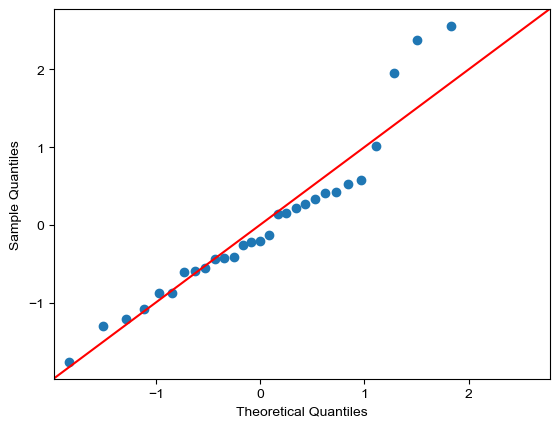

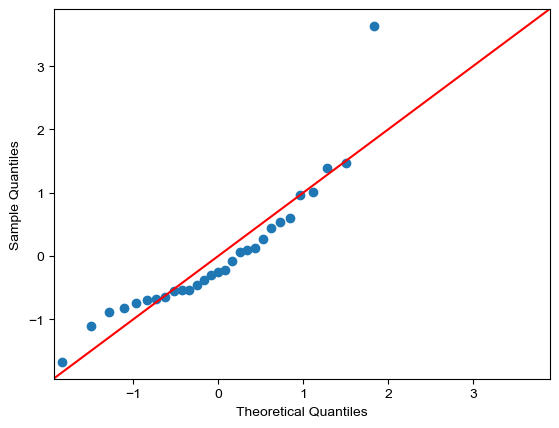

In [45]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=gb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff = sm.stats.anova_lm(model, typ=2)
anova_test_sex_diff['Significance'] = anova_test_sex_diff['PR(>F)'].apply(check_significance)
test_sex_diff_stats['Significance'] = test_sex_diff_stats['Corrected p-value'].apply(check_significance)


model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=fb).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff_f = sm.stats.anova_lm(model, typ=2)
anova_test_sex_diff_f['Significance'] = anova_test_sex_diff_f['PR(>F)'].apply(check_significance)
test_sex_diff_stats_f['Significance'] = test_sex_diff_stats_f['Corrected p-value'].apply(check_significance)

display(anova_test_sex_diff,  test_sex_diff_stats, anova_test_sex_diff_f, test_sex_diff_stats_f)
fig2_stats.update({'h_anova_test_licks_sex_diff': anova_test_sex_diff,
                   'h_test_licks_sex_diff_stat': test_sex_diff_stats,
                   'k_anova_test_licks_sex_diff_f': anova_test_sex_diff_f,
                   'k_test_licks_sex_diff_stat_f': test_sex_diff_stats_f})

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,1.0627,0.084,12.595,0.000,0.897,1.228,****
C(sex)[T.M],0.5342,0.116,4.617,0.000,0.307,0.761,****
C(Chr2)[T.True],0.7904,0.143,5.532,0.000,0.510,1.070,****
C(sex)[T.M]:C(Chr2)[T.True],-0.5236,0.190,-2.757,0.006,-0.896,-0.151,**


,comparison,Chr2,coef,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,0.534157,4.617460,3.884664e-06,NaN,1.165395e-05,****
1,Male vs Female,True,0.010579,0.070234,9.440072e-01,NaN,9.440072e-01,ns
2,Stim vs Control,NaN,0.790358,5.531552,3.174096e-08,F,1.269638e-07,****
3,Stim vs Control,NaN,0.266780,2.132240,3.298716e-02,M,6.488616e-02,ns


,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.6881,0.071,9.674,0.000,0.549,0.827,****
C(sex)[T.M],0.0778,0.092,0.843,0.399,-0.103,0.259,ns
C(Chr2)[T.True],0.2479,0.098,2.539,0.011,0.057,0.439,*
C(sex)[T.M]:C(Chr2)[T.True],0.8660,0.142,6.101,0.000,0.588,1.144,****


,comparison,Chr2,coef,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,0.077823,0.843409,3.989996e-01,NaN,3.989996e-01,ns
1,Male vs Female,True,0.943861,8.750148,2.130731e-18,NaN,6.392194e-18,****
2,Stim vs Control,NaN,0.247946,2.539134,1.111271e-02,F,2.210193e-02,*
3,Stim vs Control,NaN,1.113985,10.812827,2.993011e-27,M,1.197204e-26,****


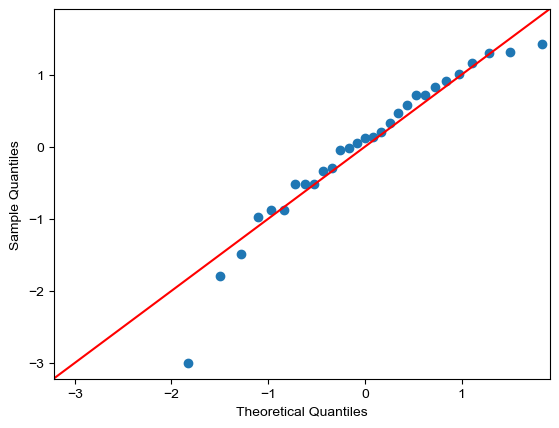

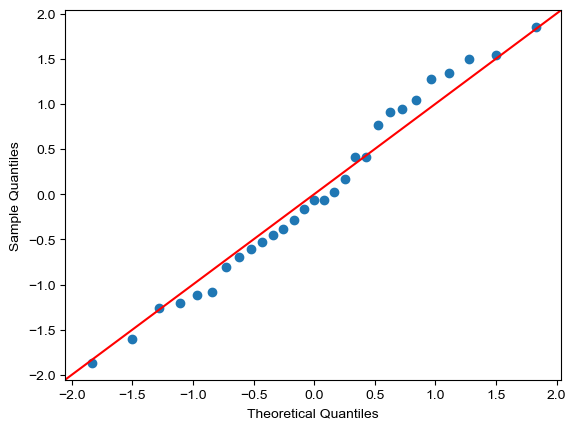

In [46]:
model_g_sex_diff = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = gb, freq_weights = gb.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model_g_sex_diff.resid_deviance, fit=True, line='45');
model_g_sex_diff_summ =pd.DataFrame(model_g_sex_diff.summary().tables[1])
model_g_sex_diff_summ.columns = model_g_sex_diff_summ.iloc[0].astype(str)
model_g_sex_diff_summ = model_g_sex_diff_summ.set_index('').iloc[1:].astype(str).astype(float)
model_g_sex_diff_summ['Significance'] = model_g_sex_diff_summ['P>|z|'].apply(check_significance)
model_g_sex_diff_pseudo_r2 = pd.DataFrame({"R2": model_g_sex_diff.pseudo_rsquared()}, index=("Cox-Snell R2",))
pref_sex_diff_stats['Significance'] = pref_sex_diff_stats['Corrected p-value'].apply(check_significance)

model_f_sex_diff = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = fb, freq_weights = fb.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model_f_sex_diff.resid_deviance, fit=True, line='45');
model_f_sex_diff_summ =pd.DataFrame(model_f_sex_diff.summary().tables[1])
model_f_sex_diff_summ.columns = model_f_sex_diff_summ.iloc[0].astype(str)
model_f_sex_diff_summ = model_f_sex_diff_summ.set_index('').iloc[1:].astype(str).astype(float)
model_f_sex_diff_summ['Significance'] = model_f_sex_diff_summ['P>|z|'].apply(check_significance)
model_f_sex_diff_pseudo_r2 = pd.DataFrame({"R2": model_f_sex_diff.pseudo_rsquared()}, index=("Cox-Snell R2",))
pref_sex_diff_stats_f['Significance'] = pref_sex_diff_stats_f['Corrected p-value'].apply(check_significance)


display(model_g_sex_diff_summ, pref_sex_diff_stats, model_f_sex_diff_summ, pref_sex_diff_stats_f)



fig2_stats.update({'i_pref_sex_diff_model': model_g_sex_diff_summ,
                   'i_pref_sex_diff_model_r2': model_g_sex_diff_pseudo_r2,
                   'i_pref_sex_diff_stats': pref_sex_diff_stats,
                   'l_pref_sex_diff_model_f': model_f_sex_diff_summ,
                   'l_pref_sex_diff_model_f_r2': model_f_sex_diff_pseudo_r2,
                   'l_pref_sex_diff_stats_f': pref_sex_diff_stats_f})

In [47]:
fint_sex_diff['Significance'] = fint_sex_diff['p-value'].apply(check_significance)
display(fint_sex_diff)
fig2_stats.update({"m_food_intake_sex_diff": fint_sex_diff})

,t,p-value,Significance
ttest,-0.576689,0.576951,ns


In [48]:
with pd.ExcelWriter(stat_save_loc/'figure2.xlsx') as writer:  
    for k,v in fig2_stats.items():
        v.to_excel(writer, sheet_name=k)

### (side analysis) - lick micro structure over training

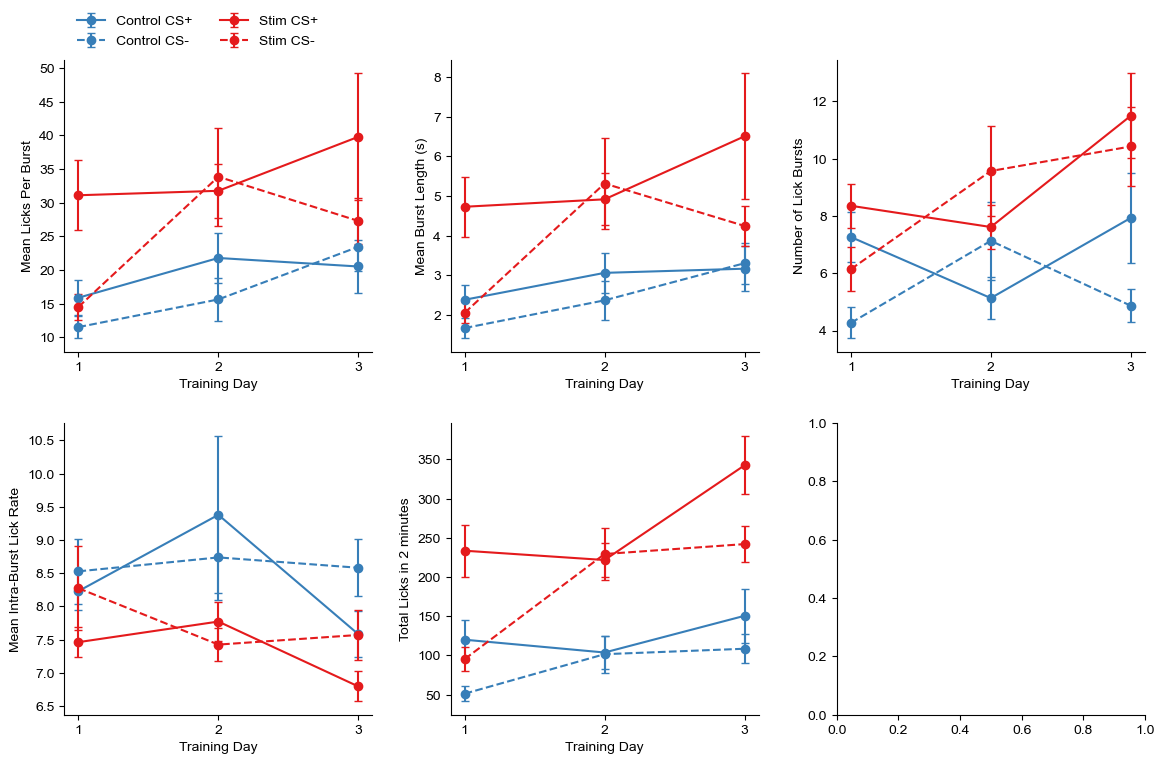

In [49]:
bursts, burst_summ = lick_microstructure(dft_train_g, 2)
fig, ax = plt.subplots(2,3, figsize = (12,8))
plot_training_micro(burst_summ, 'sizes',  ylabel = 'Mean Licks Per Burst', ax = ax[0,0]);
plot_training_micro(burst_summ, 'lens',  ylabel = 'Mean Burst Length (s)', ax = ax[0,1]);
plot_training_micro(burst_summ, 'lr',  ylabel = 'Mean Intra-Burst Lick Rate', ax = ax[1,0]);
plot_training_micro(burst_summ, 'tot',  ylabel = 'Total Licks in 2 minutes', ax = ax[1,1]);
plot_training_micro(burst_summ, 'burst_num',  ylabel = 'Number of Lick Bursts', ax = ax[0,2]);

ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[0,2].get_legend().remove()

fig.tight_layout(pad = 2.)
fig.savefig(fig_save_loc/'pdfs'/'unltd_gluc_train_microstructure_2min.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'unltd_gluc_train_microstructure_2min.svg', transparent=True, bbox_inches='tight')

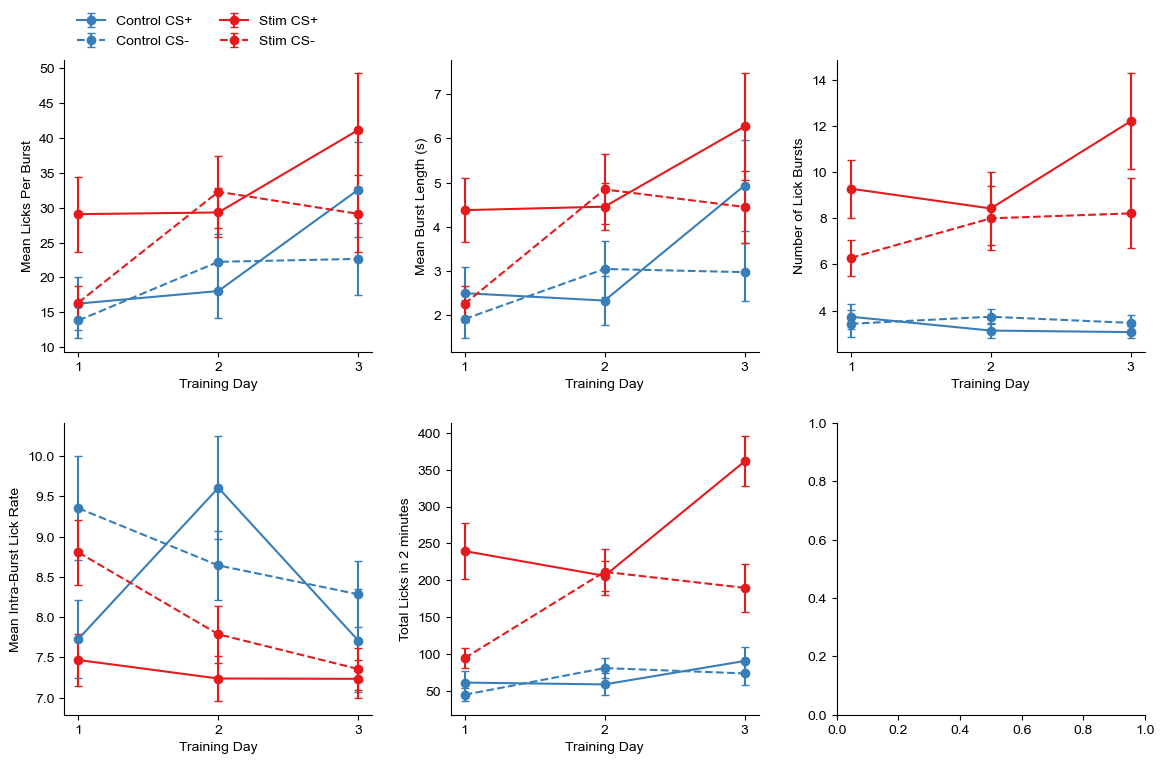

In [50]:
bursts, burst_summ = lick_microstructure(dft_train_f, 2)
fig, ax = plt.subplots(2,3, figsize = (12,8))
plot_training_micro(burst_summ, 'sizes',  ylabel = 'Mean Licks Per Burst', ax = ax[0,0]);
plot_training_micro(burst_summ, 'lens',  ylabel = 'Mean Burst Length (s)', ax = ax[0,1]);
plot_training_micro(burst_summ, 'lr',  ylabel = 'Mean Intra-Burst Lick Rate', ax = ax[1,0]);
plot_training_micro(burst_summ, 'tot',  ylabel = 'Total Licks in 2 minutes', ax = ax[1,1]);
plot_training_micro(burst_summ, 'burst_num',  ylabel = 'Number of Lick Bursts', ax = ax[0,2]);

ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[0,2].get_legend().remove()

fig.tight_layout(pad = 2.)
fig.savefig(fig_save_loc/'pdfs'/'unltd_fat_microstructure_train_2min.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'unltd_fat_microstructure_train_2min.svg', transparent=True, bbox_inches='tight')

# limited intake, food deprived

## Figure 3 - limited intake

In [51]:
print("Controls: n = ",df_test_g_ltd.loc[False,].index.get_level_values('mouse').unique().size)
print("Stim: n = ", df_test_g_ltd.loc[True,].index.get_level_values('mouse').unique().size)

Controls: n =  19
Stim: n =  18


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2509678025.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  print("Controls: n = ",df_test_g_ltd.loc[False,].index.get_level_values('mouse').unique().size)
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2509678025.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  print("Stim: n = ", df_test_g_ltd.loc[True,].index.get_level_values('mouse').unique().size)


### plots

/Users/nathanielnyema/Downloads/fnc_agrp_project/analysis/behavior/fnc_analysis.py:47: PerformanceWarning: indexing past lexsort depth may impact performance.
  return df.loc[Chr2,].pivot_table(index=['mouse','CS'], values = values)
/Users/nathanielnyema/Downloads/fnc_agrp_project/analysis/behavior/fnc_analysis.py:47: PerformanceWarning: indexing past lexsort depth may impact performance.
  return df.loc[Chr2,].pivot_table(index=['mouse','CS'], values = values)
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2928705331.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.
  _, stats_cumm_ltd_g = cumm_test_licks_plot(df_test_g_ltd.loc[True,],df_test_g_ltd.loc[False,],
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2928705331.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  _, _, p_pref_ltd = two_bottle_pref_plot_vl(df_test_g_ltd.loc[True,], df_test_g_ltd.loc[False,] ,


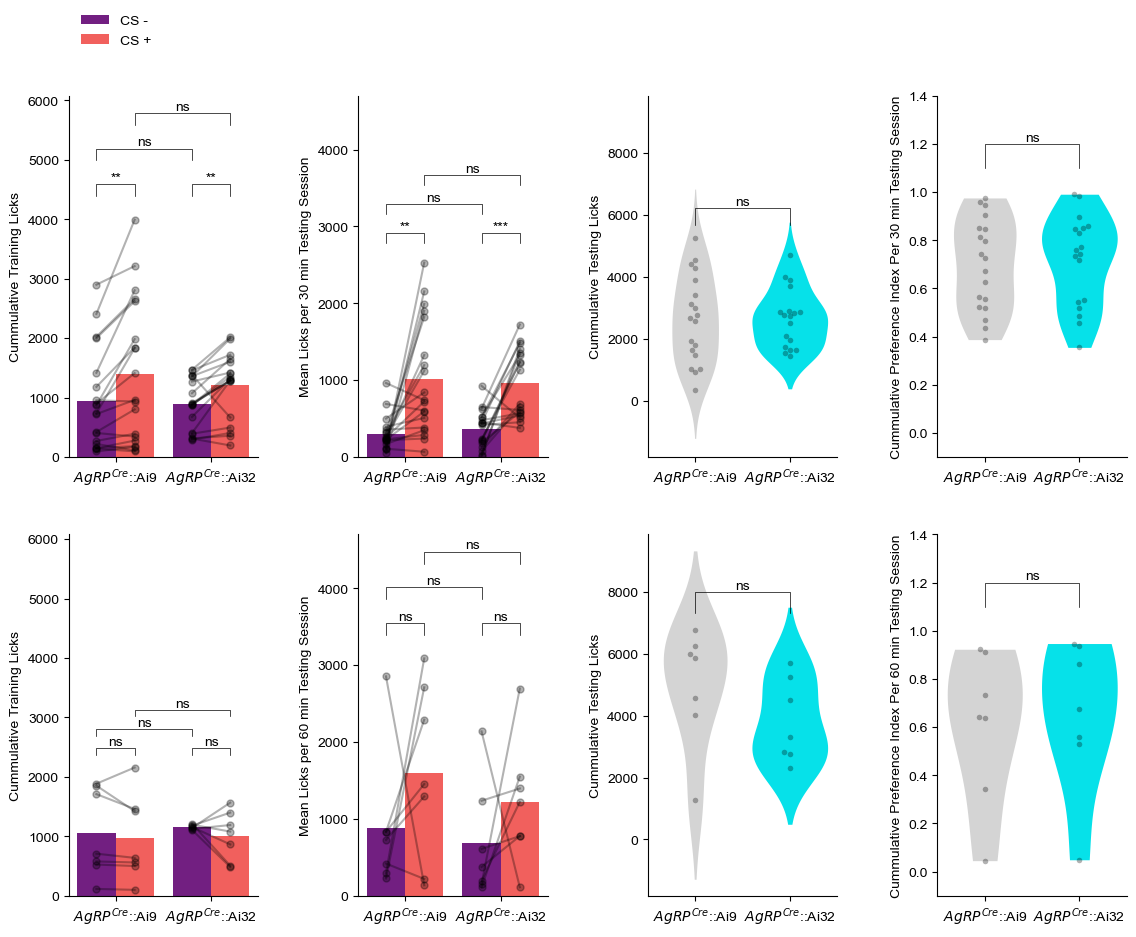

In [52]:
# create subplot
fig, ax = plt.subplots(2,4, figsize=(12,10))


# get cummulative training licks for stim and control mice
# glucose
cumm = df_train_g_ltd.total_licks.groupby(['Chr2','mouse','CS']).sum()
sg = cumm.loc[True,].to_frame()
cg =  cumm.loc[False,].to_frame()

# fat
cumm = df_train_f_ltd.total_licks.groupby(['Chr2','mouse','CS']).sum()
sf = cumm.loc[True,].to_frame()
cf =  cumm.loc[False,].to_frame()


# get the average stim and control testing licks for CS+ vs CS- flavors
# glusose
ltd_stim = average_test_data(df_test_g_ltd, Chr2=True)
ltd_ctl = average_test_data(df_test_g_ltd, Chr2=False)

# fat
ltd_stim_f = average_test_data(df_test_f_ltd, Chr2=True)
ltd_ctl_f = average_test_data(df_test_f_ltd, Chr2=False)



# create subplot
_, stats_g_cumm_ltd= two_bottle_plot(sg,cg, ax = ax[0,0])
_, stats_f_cumm_ltd = two_bottle_plot(sf,cf, ax = ax[1,0])

#reformat legends
ax[0,0].legend(ax[0,0].get_legend().legendHandles, ['CS -', 'CS +'], 
             loc = 'lower left', bbox_to_anchor = (0,1.1), frameon=False)

# label axes and add titles
ax[0,0].set_ylabel("Cummulative Training Licks")
ax[1,0].set_ylabel("Cummulative Training Licks")



# plot average CS+ and CS- testing licks for stim and control mice
_, stats_g_ltd = two_bottle_plot(ltd_stim, ltd_ctl, ax=ax[0,1]);
_, stats_f_ltd = two_bottle_plot(ltd_stim_f, ltd_ctl_f, ax=ax[1,1], t = 60);


# plot total licks
_, stats_cumm_ltd_g = cumm_test_licks_plot(df_test_g_ltd.loc[True,],df_test_g_ltd.loc[False,],
                     palette = [stim_col, ctl_col], ax = ax[0,2])
_, stats_cumm_ltd_f = cumm_test_licks_plot(df_test_f_ltd.loc[True,], df_test_f_ltd.loc[False,],
                     palette = [stim_col, ctl_col], ax = ax[1,2])


# plot cummulative pref index for stim vs control
_, _, p_pref_ltd = two_bottle_pref_plot_vl(df_test_g_ltd.loc[True,], df_test_g_ltd.loc[False,] , 
                                        ax=ax[0,3], palette = [stim_col, ctl_col]);
_, _, p_pref_ltd_f = two_bottle_pref_plot_vl(df_test_f_ltd.loc[True,], df_test_f_ltd.loc[False,] , 
                                     ax=ax[1,3], palette = [stim_col, ctl_col,], t = 60);

# remove legends
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

# ensure y limits are the same
for i in range(4):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)

# format plots
fig.tight_layout(pad=3.)
fig.savefig(fig_save_loc/'pdfs'/'fig3_ltd.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'fig3_ltd.svg', transparent=True, bbox_inches='tight')

#### stats

In [53]:
fig3_stats = {}

##### stats - glucose limited intake cummulative training licks

In [54]:
df = df_train_g_ltd.groupby(['Chr2','mouse','CS']).sum().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
cumm_train_anova_g_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                                        dv = 'total_licks', subject = 'mouse')
cumm_train_anova_g_ltd = cumm_train_anova_g_ltd.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_g_ltd['Significance'] = cumm_train_anova_g_ltd['p-value'].apply(check_significance)
stats_g_cumm_ltd = stats_g_cumm_ltd.rename(columns = {'statistic': 't', 
                                                      'pvalue': 'p-value', 
                                                      'pvalue_corr': 'Corrected p-value'})
stats_g_cumm_ltd['Significance'] = stats_g_cumm_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, cumm_train_anova_g_ltd, stats_g_cumm_ltd)
fig3_stats.update({'a_cumm_train_anova_g_ltd'   : cumm_train_anova_g_ltd,
                   'a_cumm_train_posthoc_g_ltd' : stats_g_cumm_ltd})

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2402658594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_train_g_ltd.groupby(['Chr2','mouse','CS']).sum().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.900493  0.049662
      -    0.871337  0.015221
True  +    0.902457  0.063420
      -    0.894651  0.046402

,statistic,p-value
CS,,
+,8.770240,0.005469
-,4.051405,0.051878


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,2.663871e+05,1,35,2.663871e+05,0.212357,0.647777,0.006031,NaN,ns
1,CS,2.733699e+06,1,35,2.733699e+06,27.545991,0.000008,0.440412,1.0,****
2,Interaction,1.014241e+05,1,35,1.014241e+05,1.021995,0.318984,0.028371,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,3.649390,0.001984,0.005941,17,True,**
CS+ vs. CS- $AgRP^{Cre}$::Ai9,3.868205,0.001126,0.004498,18,True,**
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,-0.633403,0.532103,0.781072,35,False,ns
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,-0.211002,0.834477,0.834477,35,False,ns


##### stats - fat limited intake cummulative training licks

In [55]:
df = df_train_f_ltd.groupby(['Chr2','mouse','CS']).sum().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, 
                                                  x.loc[~x.Chr2].total_licks), 
                                        index = ('statistic', 'p-value')))
          )
cumm_train_anova_f_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2', 
                                        dv = 'total_licks', subject = 'mouse')
cumm_train_anova_f_ltd = cumm_train_anova_f_ltd.rename(columns = {'p-unc': 'p-value'})
cumm_train_anova_f_ltd['Significance'] = cumm_train_anova_f_ltd['p-value'].apply(check_significance)
stats_f_cumm_ltd = stats_f_cumm_ltd.rename(columns = {'statistic': 't', 
                                                      'pvalue': 'p-value', 
                                                      'pvalue_corr': 'Corrected p-value'})
stats_f_cumm_ltd['Significance'] = stats_f_cumm_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, cumm_train_anova_f_ltd, stats_f_cumm_ltd)
fig3_stats.update({'e_cumm_train_anova_g_ltd'   : cumm_train_anova_f_ltd,
                   'e_cumm_train_posthoc_g_ltd' : stats_f_cumm_ltd})

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1832625944.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_train_f_ltd.groupby(['Chr2','mouse','CS']).sum().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.922997  0.493032
      -    0.848585  0.119288
True  +    0.934970  0.593917
      -    0.968339  0.886235

,statistic,p-value
CS,,
+,1.024989,0.331318
-,8.939191,0.011277


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,35358.035714,1,12,35358.035714,0.062784,0.806388,0.005205,NaN,ns
1,CS,86802.892857,1,12,86802.892857,1.533583,0.239255,0.113317,1.0,ns
2,Interaction,8540.035714,1,12,8540.035714,0.150880,0.704499,0.012417,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,-0.915033,0.395459,0.860903,6,True,ns
CS+ vs. CS- $AgRP^{Cre}$::Ai9,-0.927824,0.389298,0.860903,6,True,ns
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,0.114814,0.910951,0.920056,12,False,ns
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,0.379587,0.717257,0.920056,12,False,ns


##### stats - glucose limited intake mean total licks during testing stats

In [56]:
df = df_test_g_ltd.groupby(['Chr2','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
test_anova_g_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                                  dv = 'total_licks', subject = 'mouse')
test_anova_g_ltd = test_anova_g_ltd.rename(columns = {'p-unc': 'p-value'})
test_anova_g_ltd['Significance'] = test_anova_g_ltd['p-value'].apply(check_significance)
stats_g_ltd = stats_g_ltd.rename(columns = {'statistic': 't', 
                                            'pvalue': 'p-value', 
                                            'pvalue_corr': 'Corrected p-value'})
stats_g_ltd['Significance'] = stats_g_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_g_ltd, stats_g_ltd)
fig3_stats.update({'b_test_anova_g_ltd'   : test_anova_g_ltd,
                   'b_test_posthoc_g_ltd' : stats_g_ltd})

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1816153360.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_test_g_ltd.groupby(['Chr2','mouse','CS']).mean().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.912920  0.083764
      -    0.818898  0.002179
True  +    0.880429  0.026541
      -    0.949447  0.416411

,statistic,p-value
CS,,
+,1.892540,0.177656
-,1.221046,0.276694


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,3.576368e+02,1,35,3.576368e+02,0.001959,0.964951,0.000056,NaN,ns
1,CS,8.110824e+06,1,35,8.110824e+06,32.727068,0.000002,0.483220,1.0,****
2,Interaction,6.215563e+04,1,35,6.215563e+04,0.250797,0.619649,0.007115,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,4.710151,0.000202,0.000807,17,True,***
CS+ vs. CS- $AgRP^{Cre}$::Ai9,3.782804,0.001363,0.004082,18,True,**
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,-0.268991,0.789785,0.789785,35,False,ns
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,0.813413,0.421638,0.665497,35,False,ns


##### stats - fat unlimited intake mean total licks during testing stats

In [57]:
df = df_test_f_ltd.groupby(['Chr2','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['Chr2','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.Chr2].total_licks, x.loc[~x.Chr2].total_licks), index = ('statistic', 'p-value')))
          )
test_anova_f_ltd = pg.mixed_anova(data = df, within = 'CS', between = 'Chr2',
                                  dv = 'total_licks', subject = 'mouse')
test_anova_f_ltd = test_anova_f_ltd.rename(columns = {'p-unc': 'p-value'})
test_anova_f_ltd['Significance'] = test_anova_f_ltd['p-value'].apply(check_significance)
stats_f_ltd = stats_f_ltd.rename(columns = {'statistic': 't', 
                                            'pvalue': 'p-value', 
                                            'pvalue_corr': 'Corrected p-value'})
stats_f_ltd['Significance'] = stats_f_ltd['Corrected p-value'].apply(check_significance)

display(shapiro, levene, test_anova_f_ltd, stats_f_ltd)
fig3_stats.update({'f_test_anova_f_ltd'   : test_anova_f_ltd,
                   'f_test_posthoc_f_ltd' : stats_f_ltd})

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1736332675.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_test_f_ltd.groupby(['Chr2','mouse','CS']).mean().reset_index()


statistic   p-value
Chr2  CS                     
False +    0.924514  0.505270
      -    0.704063  0.004105
True  +    0.947445  0.706395
      -    0.808335  0.049478

,statistic,p-value
CS,,
+,1.307637,0.275123
-,0.000387,0.984619


,Source,SS,DF1,DF2,MS,F,p-value,np2,eps,Significance
0,Chr2,5.819047e+05,1,12,5.819047e+05,1.742871,0.211404,0.126820,NaN,ns
1,CS,2.715346e+06,1,12,2.715346e+06,1.998603,0.182859,0.142772,1.0,ns
2,Interaction,5.957044e+04,1,12,5.957044e+04,0.043846,0.837653,0.003641,NaN,ns


,t,p-value,Corrected p-value,df,paired,Significance
CS+ vs. CS- $AgRP^{Cre}$::Ai32,0.994549,0.358357,0.818409,6,True,ns
CS+ vs. CS- $AgRP^{Cre}$::Ai9,1.019706,0.347210,0.818409,6,True,ns
CS+ $AgRP^{Cre}$::Ai32 vs. CS+ $AgRP^{Cre}$::Ai9,-0.711154,0.492169,0.818409,12,False,ns
CS- $AgRP^{Cre}$::Ai32 vs. CS- $AgRP^{Cre}$::Ai9,-0.441542,0.666937,0.818409,12,False,ns


##### stats - limited intake cummulative testing licks

In [58]:
res_g = pd.DataFrame({"t": [stats_cumm_ltd_g[0]], 
                      "df": [stats_cumm_ltd_g[2]],
                      "p-value": [stats_cumm_ltd_g[1]], 
                      "Significance": check_significance(stats_cumm_ltd_g[1])
                     }, index = ['ttest'])
res_f = pd.DataFrame({"statistic": [stats_cumm_ltd_f[0]],
                      "df": [stats_cumm_ltd_f[2]],
                      "p-value": [stats_cumm_ltd_f[1]],
                      "Significance": check_significance(stats_cumm_ltd_f[1])
                     }, index = ['ttest'])
print("glucose")
display(res_g)
print("fat")
display(res_f)
fig1_stats.update({"c_ttest_stim_v_ctl_tot_g_ltd": res_g,
                   "g_ttest_stim_v_ctl_tot_f_ltd": res_f})

glucose


,t,df,p-value,Significance
ttest,0.044725,35,0.964608,ns


fat


,statistic,df,p-value,Significance
ttest,-1.320178,12,0.214068,ns


##### stats - glucose/fat stim v control pref comparison

In [59]:
res_g = pd.DataFrame({"U": [p_pref_ltd[0]], 
                      "p-value": [p_pref_ltd[1]],
                      "Significance": check_significance(p_pref_ltd[1])
                     }, index = ['rank sum test'])
res_f = pd.DataFrame({"U": [p_pref_ltd_f[0]], 
                      "p-value": [p_pref_ltd_f[1]],
                      "Significance": check_significance(p_pref_ltd_f[1])
                     }, index = ['rank sum test'])
print("glucose")
display(res_g)
print("fat")
display(res_f)
fig1_stats.update({"d_rank_sum_stim_v_ctl_pref_g_ltd": res_g,
                   "h_rank_sum_stim_v_ctl_pref_f_ltd": res_f})

glucose


,U,p-value,Significance
rank sum test,0.212708,0.831555,ns


fat


,U,p-value,Significance
rank sum test,0.447214,0.654721,ns


In [60]:
with pd.ExcelWriter(stat_save_loc/'figure3.xlsx') as writer:  
    for k,v in fig3_stats.items():
        v.to_excel(writer, sheet_name=k)

## (extra analysis)- validation of limited intake during training

/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2827295948.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  training_plot(df_train_g_ltd.loc[True,], df_train_g_ltd.loc[False,],
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2827295948.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  _, s, c = plot_t_to_end(dft_train_g_ltd.loc[True,],dft_train_g_ltd.loc[False,],


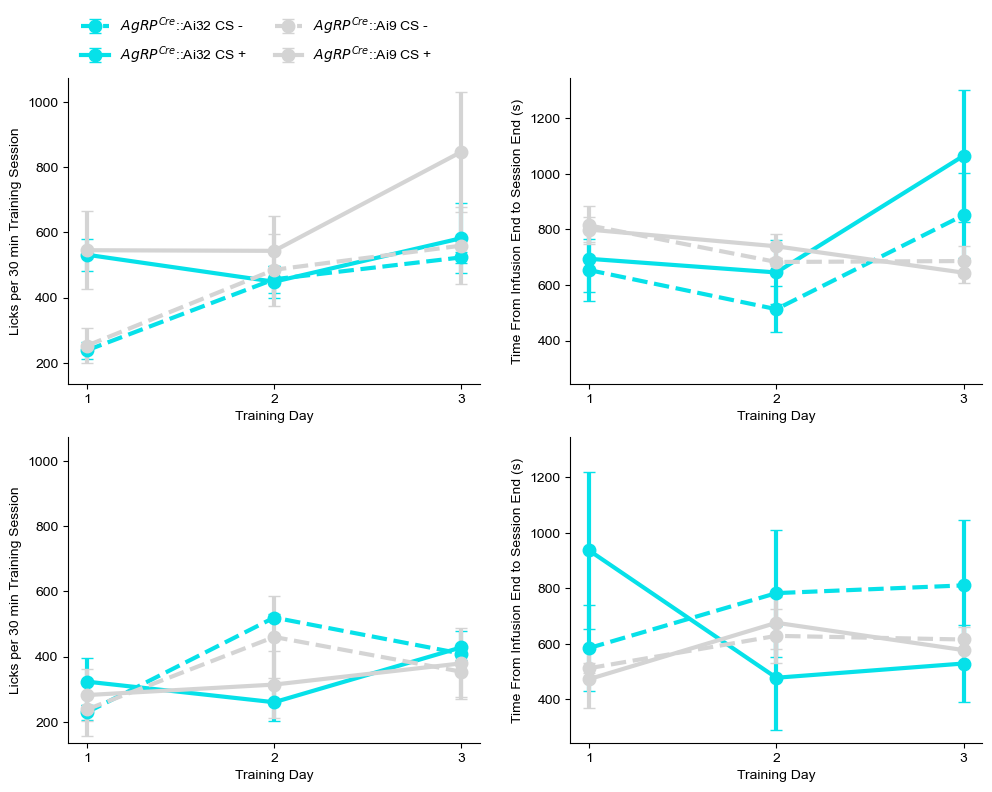

In [61]:
# create subplots
fig, ax = plt.subplots(2,2, figsize = (10,8))

# plot training licks
training_plot(df_train_g_ltd.loc[True,], df_train_g_ltd.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[0,0]);
training_plot(df_train_f_ltd.loc[True,], df_train_f_ltd.loc[False,], 
              colors = [stim_col, ctl_col], ax = ax[1,0]);


# validate that controls and stim mice had bottles for equivalent amounts of time
_, s, c = plot_t_to_end(dft_train_g_ltd.loc[True,],dft_train_g_ltd.loc[False,],
              colors = [stim_col, ctl_col], ax = ax[0,1]);
tend = pd.concat({True: s, False: c}, names = ["Chr2"])
_, s, c = plot_t_to_end(dft_train_f_ltd.loc[True,],dft_train_f_ltd.loc[False,],
              colors = [stim_col, ctl_col], ax = ax[1,1]);
tend_f = pd.concat({True: s, False: c}, names = ["Chr2"])



# remove extra legends
ax[0,1].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,0].get_legend().remove()
# ax[1,3].get_legend().remove()

# adjust y axis limits
for i in range(2):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)



#format the figure
fig.tight_layout(pad = 1.)

# save the figure
fig.savefig(fig_save_loc/'pdfs'/'ltd_train.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'ltd_train.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - limited intake validation of equal training licks

In [62]:
ltd_val = (df_train_g_ltd.groupby(['day','CS'])
                         .total_licks
                         .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                         .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
ltd_val['pvalue_corr'] = multipletests(ltd_val.pvalue, method = 'holm-sidak')[1]

ltd_val_f = (df_train_f_ltd.groupby(['day','CS'])
                         .total_licks
                         .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                         .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
ltd_val_f['pvalue_corr'] = multipletests(ltd_val_f.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(ltd_val)
print('\nfat')
display(ltd_val_f)

# limited_intake_stats.update({'train_ltd_val_g': ltd_val,
#                              'train_ltd_val_f': ltd_val_f})


glucose


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/3239949036.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.105217  0.916804     0.997033
    -   -0.230021  0.819415     0.997033
1   +   -0.795754  0.431539     0.940639
    -   -0.243852  0.808769     0.997033
2   +   -1.238350  0.239265     0.806180
    -   -0.303623  0.766615     0.997033


fat


statistic    pvalue  pvalue_corr
day CS                                  
0   +    0.384267  0.707504     0.994340
    -   -0.105449  0.917762     0.994340
1   +   -0.459031  0.654416     0.994340
    -    0.472958  0.644730     0.994340
2   +    0.413000  0.686891     0.994340
    -    0.682769  0.507720     0.985768

##### stats - limited intake validation of equal time to end

In [63]:
tend_val = (tend.groupby(['day','CS'])
                .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
tend_val['pvalue_corr'] = multipletests(tend_val.pvalue, method = 'holm-sidak')[1]
tend_val_f = (tend_f.groupby(['day','CS'])
                .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = True))
                .apply(lambda x: pd.Series(x, index = ('statistic', 'pvalue'))))
tend_val_f['pvalue_corr'] = multipletests(tend_val_f.pvalue, method = 'holm-sidak')[1]

print('glucose')
display(tend_val)
print('\nfat')
display(tend_val_f)

# limited_intake_stats.update({'train_tend_val_g': tend_val,
#                              'train_tend_val_f': tend_val_f})


glucose


statistic    pvalue  pvalue_corr
day CS                                  
0   +   -0.841487  0.405788     0.694679
    -   -1.252064  0.218849     0.627660
1   +   -0.781292  0.439884     0.694679
    -   -2.092926  0.043672     0.235035
2   +    1.756548  0.104457     0.423989
    -    1.022685  0.326632     0.694679


fat


statistic    pvalue  pvalue_corr
day CS                                  
0   +    1.532405  0.151353     0.626437
    -    0.468084  0.648112     0.907339
1   +   -0.945282  0.363160     0.895251
    -    0.619003  0.547486     0.907339
2   +   -0.331149  0.746243     0.907339
    -    0.812234  0.432476     0.896262

## Supplemental Figure 3 - sex differences in limited intake data


/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/python3.11/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


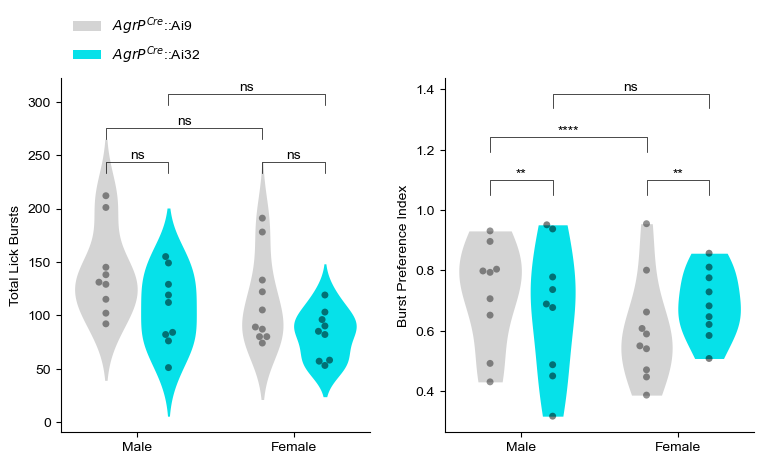

In [64]:
#get burst numbers for burst preference indices
bn_ltd = lick_microstructure(dft_test_g_ltd, 60)[1]

#get preferences
pref_ltd =  bn_ltd.groupby(['Chr2', 'sex', 'mouse', 'CS']).burst_num.sum().unstack('CS')
pref_ltd =  pd.concat({'tot': pref_ltd.sum(axis=1), 'pref': pref_ltd['+']/pref_ltd.sum(axis=1)}, axis=1).reset_index()

fig, ax = plt.subplots(1,2, figsize = (8,5))

# plot total lick bursts by sex
sns.swarmplot(pref_ltd, x='sex', y='tot', palette='dark:k', hue='Chr2', dodge=True, 
              alpha=0.5, order = ['M', 'F'], hue_order = [False, True], legend=False, 
              ax=ax[0])
g = sns.violinplot(pref_ltd, x='sex', y='tot', hue='Chr2', dodge=True,
                   linewidth=0, order = ['M', 'F'], hue_order = [False, True],
                   palette = [ctl_col, stim_col], saturation = 1, ax=ax[0])
sns.move_legend(g, loc='lower left', bbox_to_anchor=(0,1), frameon=False,
                handles = g.get_legend_handles_labels()[0], title=None,
                labels = [r'$AgrP^{Cre}$::Ai9', r'$AgrP^{Cre}$::Ai32'])
g.set_xticklabels(['Male', 'Female'])
g.set_xlabel('')
g.set_ylabel("Total Lick Bursts")

# compute stats
sex_comp = (pref_ltd.set_index(['Chr2','sex','mouse']).groupby('Chr2').tot
                    .apply(lambda x: st.ttest_ind(x.loc[:,'M'], x.loc[:,'F'], equal_var = False))
                    .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
                    .reset_index()
           )

stim_comp = (pref_ltd.set_index(['Chr2','sex','mouse']).groupby('sex').tot
                     .apply(lambda x: st.ttest_ind(x.loc[True,], x.loc[False,], equal_var = False))
                     .apply(lambda x: pd.Series(x, index = ('t', 'p-value')))
                     .reset_index()
            )

test_sex_diff_ltd_stats = pd.concat({'Male vs Female': sex_comp, 
                                     'Stim vs Control': stim_comp}, 
                                    names = ['comparison']).droplevel(1).reset_index()
test_sex_diff_ltd_stats['Corrected p-value'] = multipletests(test_sex_diff_ltd_stats['p-value'], method = 'holm-sidak')[1]
pcorr = test_sex_diff_ltd_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=pref_ltd.tot.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[0], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[0], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[0], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[0], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)


#plot preference by sex
# plot total lick bursts by sex
sns.swarmplot(pref_ltd, x='sex', y='pref', palette='dark:k', hue='Chr2', dodge=True, 
              alpha=0.5, order = ['M', 'F'], hue_order = [False, True], legend=False,
              ax=ax[1])
g = sns.violinplot(pref_ltd, x='sex', y='pref', hue='Chr2', dodge=True, legend=False,
                   cut=0, linewidth=0, order = ['M', 'F'], hue_order = [False, True],
                   palette = [ctl_col, stim_col], saturation = 1, ax=ax[1])
g.get_legend().remove()
g.set_xticklabels(['Male', 'Female'])
g.set_xlabel('')
g.set_ylabel("Burst Preference Index")


# compute stats
sex_comp = (pref_ltd.groupby('Chr2')
                    .apply(lambda x: smf.glm('pref ~ 1 + sex', data = x.reset_index(), 
                                             family = sm.families.Binomial(), 
                                             freq_weights = x.tot).fit())
                    .apply(lambda x:  pd.Series({'coef': x.params['sex[T.M]'], 
                                                 't': x.tvalues['sex[T.M]'], 
                                                 'p-value': x.pvalues['sex[T.M]']}))
                    .reset_index()
)

stim_comp = (pref_ltd.groupby('sex')
                     .apply(lambda x: smf.glm('pref ~ 1 + Chr2', data = x, 
                                              family = sm.families.Binomial(), 
                                              freq_weights = x.tot).fit())
                     .apply(lambda x:  pd.Series({'coef': x.params['Chr2[T.True]'], 
                                                  't': x.tvalues['Chr2[T.True]'], 
                                                  'p-value': x.pvalues['Chr2[T.True]']}))
                     .reset_index()
)

pref_sex_diff_ltd_stats = pd.concat({'Male vs Female': sex_comp, 
                                     'Stim vs Control': stim_comp}, 
                                    names = ['comparison']).droplevel(1).reset_index()
pref_sex_diff_ltd_stats['Corrected p-value'] = multipletests(pref_sex_diff_ltd_stats['p-value'], method = 'holm-sidak')[1]
pcorr = pref_sex_diff_ltd_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=pref_ltd.pref.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  ax[1], x1=.2, x2=1.2, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  ax[1], x1=-.2, x2=.8, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  ax[1], x1=.8, x2=1.2, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  ax[1], x1=-.2, x2=.2, yy=1.1*y, h=.05*y)

fig.tight_layout(pad=2.)
sns.despine()

fig.savefig(fig_save_loc/'pdfs'/'supp_fig3_sex_diff_ltd_g.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'supp_fig3_sex_diff_ltd_g.svg', transparent=True, bbox_inches='tight')

#### stats

In [65]:
supp_fig3_stats = {}

##### stats - total lick bursts

,sum_sq,df,F,PR(>F),Significance
"C(sex, Sum)",5890.725446,1.0,4.480223,0.041916,*
"C(Chr2, Sum)",9904.935972,1.0,7.533252,0.009723,**
"C(sex, Sum):C(Chr2, Sum)",19.111396,1.0,0.014535,0.904769,ns
Residual,43389.344444,33.0,NaN,NaN,ns


,comparison,Chr2,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,1.398847,0.179989,NaN,0.215536,ns
1,Male vs Female,True,1.699966,0.111804,NaN,0.215536,ns
2,Stim vs Control,NaN,-2.054684,0.058884,F,0.215536,ns
3,Stim vs Control,NaN,-1.895304,0.076683,M,0.215536,ns


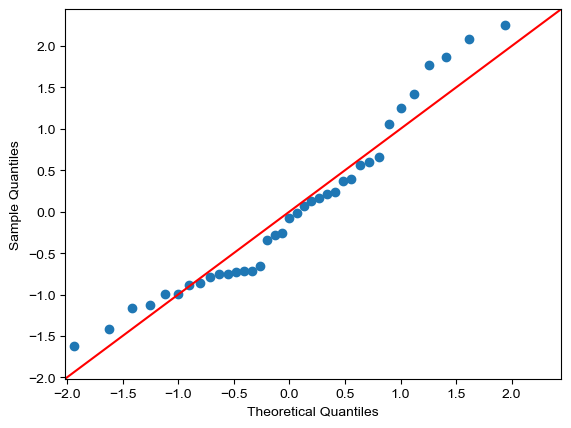

In [66]:
model = smf.ols('tot ~ C(sex, Sum)*C(Chr2, Sum)', data=pref_ltd).fit()
sm.qqplot(model.resid,fit=True, line='45');
anova_test_sex_diff_ltd = sm.stats.anova_lm(model, typ=2)
anova_test_sex_diff_ltd['Significance'] = anova_test_sex_diff_ltd['PR(>F)'].apply(check_significance)
test_sex_diff_ltd_stats['Significance'] = test_sex_diff_ltd_stats['Corrected p-value'].apply(check_significance)


display(anova_test_sex_diff_ltd,  test_sex_diff_ltd_stats)
supp_fig3_stats.update({'a_anova_test_licks_sex_diff_ltd': anova_test_sex_diff_ltd,
                        'a_test_licks_sex_diff_ltd_stat': test_sex_diff_ltd_stats})

##### stats - burst preference index

,coef,std err,z,P>|z|,[0.025,0.975],Significance
,,,,,,,
Intercept,0.5301,0.061,8.639,0.000,0.410,0.650,****
C(sex)[T.M],0.4748,0.088,5.378,0.000,0.302,0.648,****
C(Chr2)[T.True],0.3488,0.101,3.444,0.001,0.150,0.547,**
C(sex)[T.M]:C(Chr2)[T.True],-0.6179,0.138,-4.476,0.000,-0.889,-0.347,****


,comparison,Chr2,coef,t,p-value,sex,Corrected p-value,Significance
0,Male vs Female,False,0.474804,5.378115,7.526988e-08,NaN,3.010795e-07,****
1,Male vs Female,True,-0.143129,-1.348637,1.774536e-01,NaN,1.774536e-01,ns
2,Stim vs Control,NaN,0.348833,3.444467,5.721854e-04,F,1.715574e-03,**
3,Stim vs Control,NaN,-0.269100,-2.868427,4.125187e-03,M,8.233357e-03,**


,R2
Cox-Snell R2,0.568654


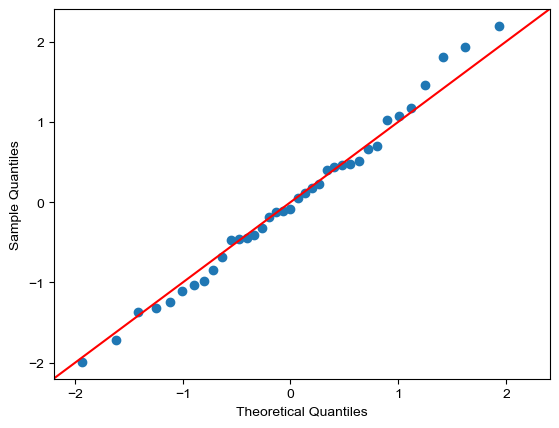

In [67]:
model_g_sex_diff_ltd = smf.glm('pref ~ 1 +  C(sex)*C(Chr2)', data = pref_ltd, freq_weights = pref_ltd.tot, family = sm.families.Binomial()).fit()
sm.qqplot(model_g_sex_diff_ltd.resid_deviance, fit=True, line='45');
model_g_sex_diff_ltd_summ =pd.DataFrame(model_g_sex_diff_ltd.summary().tables[1])
model_g_sex_diff_ltd_summ.columns = model_g_sex_diff_ltd_summ.iloc[0].astype(str)
model_g_sex_diff_ltd_summ = model_g_sex_diff_ltd_summ.set_index('').iloc[1:].astype(str).astype(float)
model_g_sex_diff_ltd_summ['Significance'] = model_g_sex_diff_ltd_summ['P>|z|'].apply(check_significance)
model_g_sex_diff_ltd_pseudo_r2 = pd.DataFrame({"R2": model_g_sex_diff_ltd.pseudo_rsquared()}, index=("Cox-Snell R2",))
pref_sex_diff_ltd_stats['Significance'] = pref_sex_diff_ltd_stats['Corrected p-value'].apply(check_significance)


display(model_g_sex_diff_ltd_summ, pref_sex_diff_ltd_stats,model_g_sex_diff_ltd_pseudo_r2)



supp_fig3_stats.update({'b_pref_sex_diff_model_ltd': model_g_sex_diff_ltd_summ,
                        'b_pref_sex_diff_model_ltd_r2': model_g_sex_diff_ltd_pseudo_r2,
                        'b_pref_sex_diff_stats_ltd': pref_sex_diff_ltd_stats})

In [68]:
with pd.ExcelWriter(stat_save_loc/'supp_fig3.xlsx') as writer:  
    for k,v in supp_fig3_stats.items():
        v.to_excel(writer, sheet_name=k)

### alternate visualization

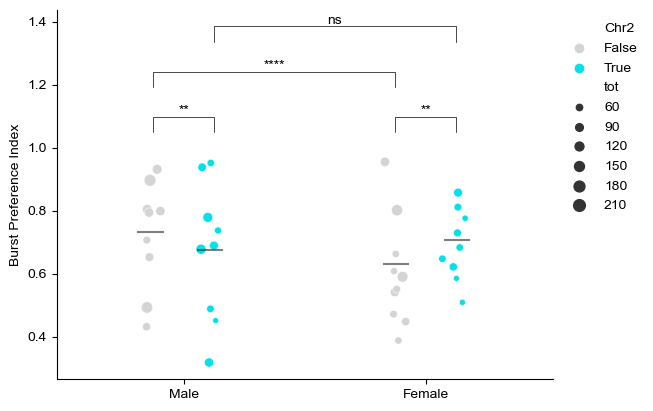

In [69]:
pref_ltd.groupby(['Chr2','sex']).pref.median()
#plot preference by sex
pref_ltd['x'] = (0.5*pref_ltd.Chr2.astype(int)) + (2*(pref_ltd.sex=='F').astype(int) - 1) + 0.05*np.random.randn(len(pref_ltd))
g = sns.scatterplot(pref_ltd, x='x', y='pref', size = 'tot', hue = 'Chr2', palette = [ctl_col, stim_col])
xmn = pref_ltd.groupby(['Chr2','sex']).x.mean()
pmn = pref_ltd.groupby(['Chr2','sex']).apply(lambda x: (x.tot@x.pref)/x.tot.sum())
for i,j in zip(xmn, pmn):
    g.plot([i-0.1, i+0.1], [j,j], color = 'k', alpha=0.5)
    
    
g.set_xlim(-1.8,2.3)
g.set_xticks([-0.75, 1.25])
g.set_xticklabels(['Male', 'Female'])
g.set_xlabel("")
g.set_ylabel("Burst Preference Index")
g.legend(loc = 'upper left', bbox_to_anchor = (1,1), frameon=False)



# compute stats
sex_comp = (pref_ltd.groupby('Chr2')
                    .apply(lambda x: smf.glm('pref ~ 1 + sex', data = x.reset_index(), 
                                             family = sm.families.Binomial(), 
                                             freq_weights = x.tot).fit())
                    .apply(lambda x:  pd.Series({'coef': x.params['sex[T.M]'], 
                                                 't': x.tvalues['sex[T.M]'], 
                                                 'p-value': x.pvalues['sex[T.M]']}))
                    .reset_index()
)

stim_comp = (pref_ltd.groupby('sex')
                     .apply(lambda x: smf.glm('pref ~ 1 + Chr2', data = x, 
                                              family = sm.families.Binomial(), 
                                              freq_weights = x.tot).fit())
                     .apply(lambda x:  pd.Series({'coef': x.params['Chr2[T.True]'], 
                                                  't': x.tvalues['Chr2[T.True]'], 
                                                  'p-value': x.pvalues['Chr2[T.True]']}))
                     .reset_index()
)

pref_sex_diff_ltd_stats = pd.concat({'Male vs Female': sex_comp, 
                                     'Stim vs Control': stim_comp}, 
                                    names = ['comparison']).droplevel(1).reset_index()
pref_sex_diff_ltd_stats['Corrected p-value'] = multipletests(pref_sex_diff_ltd_stats['p-value'], method = 'holm-sidak')[1]
pcorr = pref_sex_diff_ltd_stats.set_index(['comparison', 'Chr2', 'sex'])['Corrected p-value']

# plot the stats
y=pref_ltd.pref.max()
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', True].iloc[0],
                  g, x1=-0.5, x2=1.5, yy=1.4*y, h=.05*y)
plot_significance(pcorr.droplevel('sex').loc['Male vs Female', False].iloc[0],
                  g, x1=-1, x2=1, yy=1.25*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'F'].iloc[0], 
                  g, x1=1, x2=1.5, yy= 1.1*y, h=.05*y)
plot_significance(pcorr.droplevel('Chr2').loc['Stim vs Control', 'M'].iloc[0], 
                  g, x1=-1, x2=-.5, yy=1.1*y, h=.05*y)

sns.despine()

## comparing control two bottle test performance limited vs unlimited


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/3023631034.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  _, stat_ltd_unltd_tot_g = cumm_test_licks_plot(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/3023631034.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  _, _, stat_ltd_unltd_pref_g = two_bottle_pref_plot_vl(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,


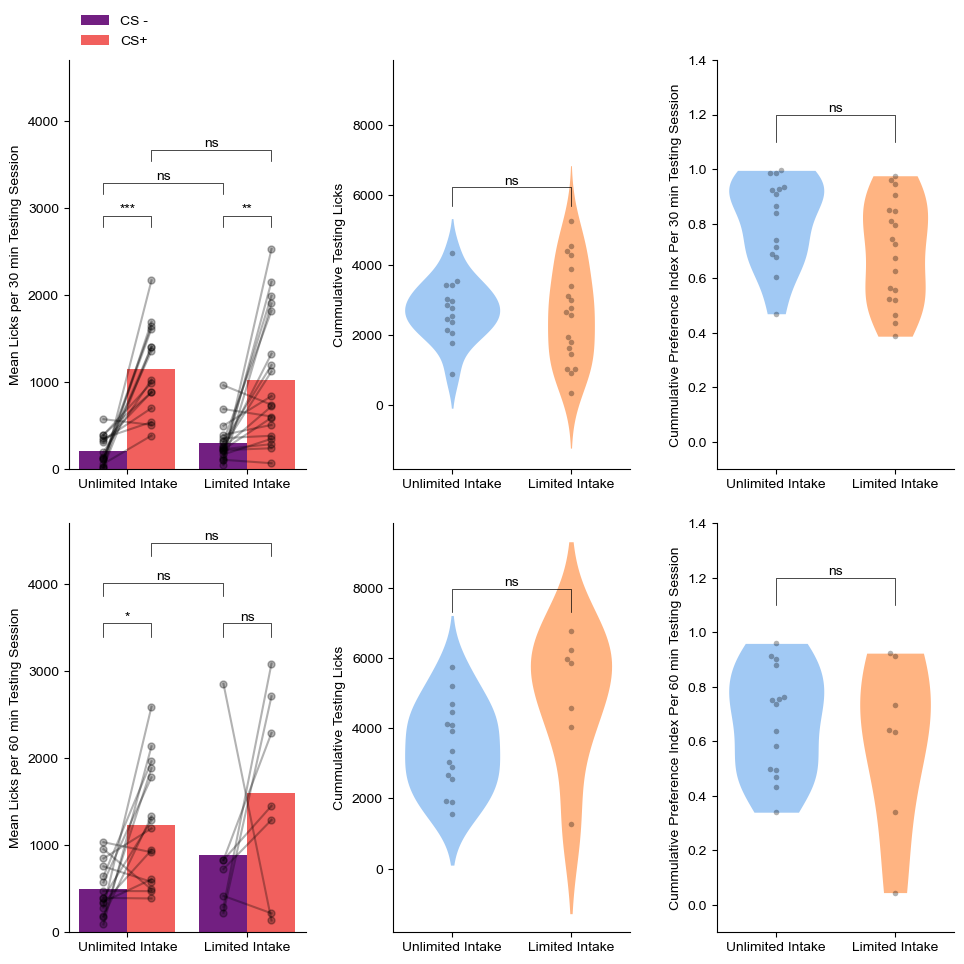

In [70]:
fig, ax = plt.subplots(2,3, figsize=(10,10))

# plot mean cs+ and cs- testing licks
_, stat_ltd_unltd_g = two_bottle_plot(ltd_ctl, normal_ctl,  ax=ax[0,0],
                                      groups= ['Limited Intake', 'Unlimited Intake']);
_, stat_ltd_unltd_f = two_bottle_plot(ltd_ctl_f, normal_ctl_f,  ax=ax[1,0], t = 60,
                                      groups= ['Limited Intake', 'Unlimited Intake']);

# plot cummulative testing licks
_, stat_ltd_unltd_tot_g = cumm_test_licks_plot(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                               groups= ['Limited Intake', 'Unlimited Intake'], 
                                               ax=ax[0,1], palette= sns.color_palette('pastel',2)[::-1])
_, stat_ltd_unltd_tot_f = cumm_test_licks_plot(df_test_f_ltd.loc[False,], df_test_f.loc[False,] , 
                                               groups= ['Limited Intake', 'Unlimited Intake'],
                                               ax=ax[1,1], palette= sns.color_palette('pastel',2)[::-1])

# plot lick preference index
_, _, stat_ltd_unltd_pref_g = two_bottle_pref_plot_vl(df_test_g_ltd.loc[False,], df_test_g.loc[False,] ,
                                                      groups= ['Limited Intake', 'Unlimited Intake'], 
                                                      ax=ax[0,2], palette= sns.color_palette('pastel',2)[::-1]);
_, _, stat_ltd_unltd_pref_f = two_bottle_pref_plot_vl(df_test_f_ltd.loc[False,], df_test_f.loc[False,] ,
                                                      groups= ['Limited Intake', 'Unlimited Intake'], 
                                                      ax=ax[1,2], t = 60, palette= sns.color_palette('pastel',2)[::-1]);

# remove legends
ax[1,0].get_legend().remove()

# adjust the y-limits
for i in range(3):
    l = np.array([ax[0,i].get_ylim(), ax[1,i].get_ylim()])
    bnd = (l[:,0].min(), l[:,1].max())
    ax[0,i].set_ylim(bnd)
    ax[1,i].set_ylim(bnd)
    
# format plots
fig.tight_layout(pad=2.0)

# save the figure
fig.savefig(fig_save_loc/'pdfs'/'ltd_ctl_v_unltd_ctl.pdf', transparent=True, bbox_inches='tight')
fig.savefig(fig_save_loc/'svgs'/'ltd_ctl_v_unltd_ctl.svg', transparent=True, bbox_inches='tight')

#### stats

##### stats - glucose unlimited vs limited mean CS+ and CS- licks

In [71]:
df = pd.concat({True: df_test_g_ltd.loc[False,], 
                False: df_test_g.loc[False,]},
               names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['limited','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.limited].total_licks, x.loc[~x.limited].total_licks), index = ('statistic', 'p-value')))
          )
anova_res = pg.mixed_anova(data = df, within = 'CS', between = 'limited', dv = 'total_licks', subject = 'mouse')
display(shapiro, levene, anova_res, stat_ltd_unltd_g)
# limited_intake_stats.update({ 'test_shapiro_ltd_unltd_g' : shapiro,
#                                'test_levene_ltd_unltd_g'  : levene ,
#                                'test_anova_ltd_unltd_g'   : anova_res,
#                                'test_posthoc_ltd_unltd_g': stat_ltd_unltd_g})


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1976743993.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = pd.concat({True: df_test_g_ltd.loc[False,],
/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/1976743993.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()


statistic   p-value
limited CS                     
False   +    0.960600  0.702824
        -    0.911952  0.145072
True    +    0.912920  0.083764
        -    0.818898  0.002179

,statistic,p-value
CS,,
+,1.145549,0.292490
-,0.001401,0.970373


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,limited,5.985741e+03,1,32,5.985741e+03,0.033615,8.556851e-01,0.001049,NaN
1,CS,1.127024e+07,1,32,1.127024e+07,39.737856,4.517528e-07,0.553931,1.0
2,Interaction,1.970808e+05,1,32,1.970808e+05,0.694889,4.106857e-01,0.021254,NaN


,statistic,pvalue,pvalue_corr,df,paired
CS+ vs. CS- Limited Intake,3.782804,0.001363,0.004082,18,True
CS+ vs. CS- Unlimited Intake,5.623017,0.000063,0.000251,14,True
CS+ Limited Intake vs. CS+ Unlimited Intake,-0.591720,0.558248,0.558248,32,False
CS- Limited Intake vs. CS- Unlimited Intake,1.338128,0.190286,0.344364,32,False


##### stats - glucose unlimited vs limited mean CS+ and CS- licks

In [72]:
df = pd.concat({True: df_test_f_ltd.loc[False,], 
                False: df_test_f.loc[False,]},
               names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()
shapiro = (df.groupby(['limited','CS'])
             .total_licks
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
levene  = (df.groupby('CS')
             .apply(lambda x: pd.Series(st.levene(x.loc[x.limited].total_licks, x.loc[~x.limited].total_licks), index = ('statistic', 'p-value')))
          )
anova_res = pg.mixed_anova(data = df, within = 'CS', between = 'limited', dv = 'total_licks', subject = 'mouse')
display(shapiro, levene, anova_res, stat_ltd_unltd_f)
# limited_intake_stats.update({ 'test_shapiro_ltd_unltd_f' : shapiro,
#                                'test_levene_ltd_unltd_f'  : levene ,
#                                'test_anova_ltd_unltd_f'   : anova_res,
#                                'test_posthoc_ltd_unltd_f': stat_ltd_unltd_f})


/var/folders/qf/0vf10ypd4m736p1sw5dw10v00000gn/T/ipykernel_22256/2186379068.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  names = ["limited"]).groupby(['limited','mouse','CS']).mean().reset_index()


statistic   p-value
limited CS                     
False   +    0.927676  0.251834
        -    0.943376  0.426726
True    +    0.924514  0.505270
        -    0.704063  0.004105

,statistic,p-value
CS,,
+,2.760479,0.112215
-,1.970012,0.175783


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,limited,1.315077e+06,1,20,1.315077e+06,4.822610,0.040050,0.194283,NaN
1,CS,5.871029e+06,1,20,5.871029e+06,7.570947,0.012305,0.274599,1.0
2,Interaction,1.232767e+03,1,20,1.232767e+03,0.001590,0.968591,0.000079,NaN


,statistic,pvalue,pvalue_corr,df,paired
CS+ vs. CS- Limited Intake,1.019706,0.347210,0.675482,6,True
CS+ vs. CS- Unlimited Intake,3.320959,0.005047,0.020037,14,True
CS+ Limited Intake vs. CS+ Unlimited Intake,0.758789,0.469533,0.675482,20,False
CS- Limited Intake vs. CS- Unlimited Intake,1.092787,0.312806,0.675482,20,False


##### stats - unlimited vs limited cummulative licks

In [73]:
# stat_ltd_unltd_tot_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_tot_g}, index = ['statistic', 'pvalue']).T
# stat_ltd_unltd_tot_f_df = pd.DataFrame({'ttest': stat_ltd_unltd_tot_f}, index = ['statistic', 'pvalue']).T

# print('glucose')
# display(stat_ltd_unltd_tot_g_df)
# print('\nfat')
# display(stat_ltd_unltd_tot_f_df)

# limited_intake_stats.update({'test_ltd_v_unltd_tot_g': stat_ltd_unltd_tot_g_df,
#                              'test_ltd_v_unltd_tot_f': stat_ltd_unltd_tot_f_df})

##### stats - unlimited vs limited pref

In [74]:
stat_ltd_unltd_pref_g_df = pd.DataFrame({'ttest': stat_ltd_unltd_pref_g}, index = ['statistic', 'pvalue']).T
stat_ltd_unltd_pref_f_df = pd.DataFrame({'ttest': stat_ltd_unltd_pref_f}, index = ['statistic', 'pvalue']).T


print('glucose')
display(stat_ltd_unltd_pref_g_df)
print('\nfat')
display(stat_ltd_unltd_pref_f_df)

# limited_intake_stats.update({'test_ltd_v_unltd_pref_g': stat_ltd_unltd_pref_g_df,
#                              'test_ltd_v_unltd_pref_f': stat_ltd_unltd_pref_f_df})

glucose


,statistic,pvalue
ttest,-1.855615,0.063508



fat


,statistic,pvalue
ttest,-0.246718,0.805127


In [75]:
# with pd.ExcelWriter('../stats/raw/limited_intake.xlsx') as writer:  
#     for k,v in limited_intake_stats.items():
#         v.to_excel(writer, sheet_name=k)

## Lickometer Validation

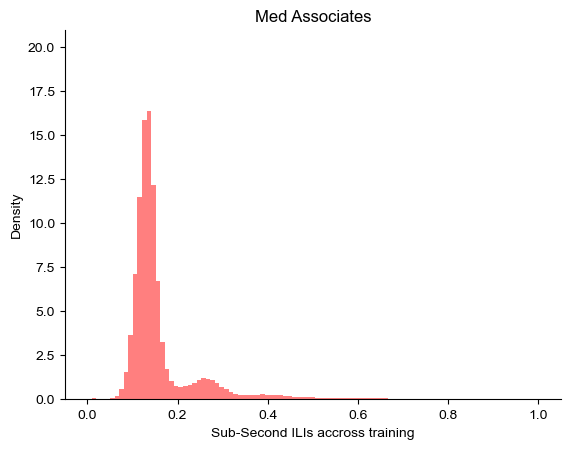

In [76]:
#load unlimited intake
#compute ilis
ilis = dft_train_g.time.groupby(['mouse','day','CS']).apply(lambda x: (x.iloc[1:] - x.iloc[:-1]).reset_index(drop=True))
subs = ilis.loc[ilis<1]
bins = np.linspace(0,1, 100)
plt.hist(subs,bins, alpha = 0.5, density = True, color='r');
plt.xlabel('Sub-Second ILIs accross training')
plt.ylabel('Density')
plt.title('Med Associates')
plt.ylim(0,21)
sns.despine()
plt.savefig('figures/pdfs/ili_resolutin_benchmark_med.pdf')
plt.savefig('figures/svgs/ili_resolutin_benchmark_med.svg')